# **PRE process data**

Install and Import

In [95]:
!pip -q install -U yfinance
!pip install -U pandas_ta

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
from sklearn.preprocessing import StandardScaler

Dowload price from OHLCV

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import pandas_ta as ta
from sklearn.preprocessing import StandardScaler

tickers = ["AAPL", "MSFT", "NVDA", "TSLA", "GOOGL", "AMZN", "META", "NFLX", "AMD", "INTC",
    "JPM", "V", "MA", "ORCL", "XOM", "COST", "WMT", "PG", "JNJ", "ADBE",
    "BAC", "KO", "PEP", "CSCO", "CRM", "T", "MCD", "HON", "IBM", "QCOM",
    "UPS", "PM", "CVX", "BA", "SBUX", "GS", "CAT", "AXP", "MDT", "AMGN",
    "BLK", "SPGI", "TXN", "NEE", "MMM", "UNH", "LIN", "RTX", "LOW", "BKNG"]

START_DATE = "2018-01-01"

data = yf.download(tickers, start=START_DATE, auto_adjust=True, group_by="ticker")
dfs = []
for t in tickers:
    df_t = data[t][['Open','High','Low','Close','Volume']].dropna().copy()
    df_t['Ticker'] = t
    dfs.append(df_t)

df_all = pd.concat(dfs)
df_all.index.name = "Date"
df_all.reset_index(inplace=True)


[*********************100%***********************]  50 of 50 completed


In [3]:
df_all.head()

Price       Date       Open       High        Low      Close     Volume Ticker
0     2018-01-02  39.888719  40.390375  39.677740  40.380997  102223600   AAPL
1     2018-01-03  40.444285  40.917812  40.310668  40.373959  118071600   AAPL
2     2018-01-04  40.446638  40.664649  40.338807  40.561504   89738400   AAPL
3     2018-01-05  40.657611  41.110038  40.566188  41.023304   94640000   AAPL
4     2018-01-08  40.870930  41.166296  40.772471  40.870930   82271200   AAPL

In [4]:
df_all.tail()

Price       Date         Open         High          Low        Close  Volume  \
98545 2025-10-28  5240.580078  5275.000000  5120.569824  5120.569824  407100   
98546 2025-10-29  5200.009766  5220.000000  4928.140137  5075.859863  461600   
98547 2025-10-30  5063.390137  5279.759766  5055.000000  5080.209961  326000   
98548 2025-10-31  5065.169922  5109.830078  5029.520020  5077.740234  177200   
98549 2025-11-03  5063.600098  5085.229980  4983.290039  5030.549805  226900   

Price Ticker  
98545   BKNG  
98546   BKNG  
98547   BKNG  
98548   BKNG  
98549   BKNG

In [5]:
import numpy as np
import pandas_ta as ta

def process_stock(df, ticker):
    df = df.copy().sort_values('Date')

    # =====================
    # 1. Base derived features
    # =====================
    df['log_ret'] = np.log(df['Close']).diff()
    df['hl_spread'] = (df['High'] - df['Low']) / df['Close']
    df['high_ret'] = np.log(df['High']).diff()
    df['low_ret'] = np.log(df['Low']).diff()

    # =====================
    # 3. Volume features
    # =====================
    df['vol_log'] = np.log1p(df['Volume'])
    df['vol_ret'] = df['vol_log'].diff()  # relative change in log-volume

    # =====================
    # 4. Technical indicators (raw)
    # =====================
    df.ta.sma(close='Close', length=5, append=True)
    df.ta.sma(close='Close', length=20, append=True)
    df.ta.ema(close='Close', length=20, append=True)
    df.ta.hma(close='Close', length=20, append=True)
    df.ta.rsi(close='Close', length=14, append=True)
    df.ta.stoch(length=14, append=True)
    df.ta.cci(length=20, append=True)
    df.ta.cmf(length=20, append=True)
    df.ta.macd(close='Close', fast=12, slow=26, signal=9, append=True)
    df.ta.roc(close='Volume', length=5, append=True)
    df.ta.atr(length=14, append=True)

    # =====================
    # 5. Bollinger Bands
    # =====================
    w, s = 20, 2
    df['bb_mid'] = df['Close'].rolling(w).mean()
    df['bb_std'] = df['Close'].rolling(w).std()
    df['bb_high'] = df['bb_mid'] + s * df['bb_std']
    df['bb_low'] = df['bb_mid'] - s * df['bb_std']
    df['bb_width'] = (df['bb_high'] - df['bb_low']) / df['bb_mid']
    df['bb_percent'] = (df['Close'] - df['bb_low']) / (df['bb_high'] - df['bb_low'])

    # =====================
    # 6. Relative / normalized trend indicators (stationary transformation)
    # =====================
    trend_cols = ['SMA_5','SMA_20','EMA_20','HMA_20','bb_mid','bb_high','bb_low']
    for col in trend_cols:
        if col in df.columns:
            df[f'{col.lower()}_rel'] = df[col] / df['Close'] - 1

    # Normalize ATR, CCI
    if 'ATRr_14' in df.columns:
        df['atr_norm'] = df['ATRr_14'] / df['Close']
    elif 'ATR_14' in df.columns:
        df['atr_norm'] = df['ATR_14'] / df['Close']

    if 'CCI_20' in df.columns:
        df['cci_norm'] = df['CCI_20'] / df['Close']

    # Momentum features
    for w in [5, 10, 20]:
        df[f'mom_{w}'] = df['log_ret'].rolling(w).sum()

     # =====================
    # 6. Volume / Buying power features
    # =====================
    for w in [5, 20]:
        df[f'vol_ma_ratio_{w}'] = df['Volume'] / df['Volume'].rolling(w).mean() - 1
    df['obv'] = ta.obv(df['Close'], df['Volume'])
    df['obv_ret'] = df['obv'].pct_change()
    df['volatility_vol'] = df['Volume'].rolling(10).std() / df['Volume'].rolling(10).mean()

    # =====================
    # 7. Cyclical time features
    # =====================
    df['dow_sin'] = np.sin(2 * np.pi * df['Date'].dt.dayofweek / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['Date'].dt.dayofweek / 7)

    # =====================
    # 7. Cleanup
    # =====================
    df.dropna(inplace=True)
    df['Ticker'] = ticker

    # Drop raw non-stationary values
    drop_cols = ['Open','High','Low','Close','Volume',
                 'SMA_5','SMA_20','EMA_20','HMA_20',
                 'bb_mid','bb_high','bb_low','ATRr_14','ATR_14','CCI_20']
    df.drop(columns=drop_cols, errors='ignore', inplace=True)

    return df


In [7]:
processed_dfs = []

rename_map = {
    'SMA_5':'sma_5','SMA_20':'sma_20','EMA_20':'ema_20','RSI_14':'rsi_14',
    'MACD_12_26_9':'macd','MACDs_12_26_9':'macd_signal','MACDh_12_26_9':'macd_hist',
    'ROC_5':'vol_roc_5'
}

for t, df in zip(tickers, dfs):
    df_processed = process_stock(df.reset_index(), t)
    print(t, df_processed.shape)
    df_processed.rename(columns={k: v for k, v in rename_map.items() if k in df_processed.columns},inplace=True)
    processed_dfs.append(df_processed)

AAPL (1938, 39)
MSFT (1938, 39)
NVDA (1938, 39)
TSLA (1938, 39)
GOOGL (1938, 39)
AMZN (1938, 39)
META (1938, 39)
NFLX (1938, 39)
AMD (1938, 39)
INTC (1938, 39)
JPM (1938, 39)
V (1938, 39)
MA (1938, 39)
ORCL (1938, 39)
XOM (1938, 39)
COST (1938, 39)
WMT (1938, 39)
PG (1938, 39)
JNJ (1938, 39)
ADBE (1938, 39)
BAC (1938, 39)
KO (1938, 39)
PEP (1938, 39)
CSCO (1938, 39)
CRM (1938, 39)
T (1938, 39)
MCD (1938, 39)
HON (1938, 39)
IBM (1938, 39)
QCOM (1938, 39)
UPS (1938, 39)
PM (1938, 39)
CVX (1938, 39)
BA (1938, 39)
SBUX (1938, 39)
GS (1938, 39)
CAT (1938, 39)
AXP (1938, 39)
MDT (1938, 39)
AMGN (1938, 39)
BLK (1938, 39)
SPGI (1938, 39)
TXN (1938, 39)
NEE (1938, 39)
MMM (1938, 39)
UNH (1938, 39)
LIN (1938, 39)
RTX (1938, 39)
LOW (1938, 39)
BKNG (1938, 39)


In [8]:
processed_dfs[1].head()

Price       Date Ticker   log_ret  hl_spread  high_ret   low_ret    vol_log  \
33    2018-02-20   MSFT  0.007796   0.022110 -0.004717 -0.008643  17.246645   
34    2018-02-21   MSFT -0.013355   0.020439  0.003219  0.005260  17.108473   
35    2018-02-22   MSFT  0.002620   0.014935 -0.006771 -0.001422  17.009799   
36    2018-02-23   MSFT  0.025083   0.018180  0.014347  0.010886  17.086189   
37    2018-02-26   MSFT  0.014355   0.012576  0.014563  0.020257  17.223346   

Price   vol_ret     rsi_14  STOCHk_14_3_3  ...     mom_5    mom_10    mom_20  \
33     0.010236  58.449783      74.054945  ...  0.044175  0.056934  0.016730   
34    -0.138172  54.798469      70.853758  ...  0.022997  0.006437  0.000215   
35    -0.098674  55.384203      74.813720  ...  0.010080  0.028069  0.003706   
36     0.076391  60.706981      82.719316  ...  0.014997  0.105851  0.023250   
37     0.137157  63.448066      93.938430  ...  0.036500  0.083595  0.019042   

Price  vol_ma_ratio_5  vol_ma_ratio_20          obv   obv_ret  volatility_vol  \
33           0.025596        -0.219391   87129600.0  0.549855        0.369074   
34          -0.109799        -0.323130   60207100.0 -0.308994        0.339372   
35          -0.132841        -0.379803   84599900.0  0.405148        0.370427   
36          -0.053948        -0.330523  110929100.0  0.311220        0.349079   
37           0.088234        -0.233107  141128900.0  0.272244        0.127806   

Price   dow_sin   dow_cos  
33     0.781831  0.623490  
34     0.974928 -0.222521  
35     0.433884 -0.900969  
36    -0.433884 -0.900969  
37     0.000000  1.000000  

[5 rows x 39 columns]

In [9]:
processed_dfs[1].tail()

Price       Date Ticker   log_ret  hl_spread  high_ret   low_ret    vol_log  \
1966  2025-10-28   MSFT  0.019654   0.023890  0.035178  0.021987  17.216265   
1967  2025-10-29   MSFT -0.000960   0.017616 -0.013546 -0.007499  17.399668   
1968  2025-10-30   MSFT -0.029591   0.024441 -0.020903 -0.027598  17.529646   
1969  2025-10-31   MSFT -0.015236   0.027462 -0.010617 -0.013536  17.342059   
1970  2025-11-03   MSFT -0.001507   0.020057 -0.008271 -0.000990  16.922042   

Price   vol_ret     rsi_14  STOCHk_14_3_3  ...     mom_5    mom_10    mom_20  \
1966   0.470377  73.095928      79.623873  ...  0.046077  0.054009  0.045516   
1967   0.183404  72.346762      79.792377  ...  0.039569  0.053322  0.041164   
1968   0.129978  54.186475      63.830722  ...  0.009940  0.027282  0.019242   
1969  -0.187587  47.694947      46.884630  ... -0.011139  0.008203  0.000889   
1970  -0.420018  47.098791      29.033549  ... -0.027640  0.000464 -0.022074   

Price  vol_ma_ratio_5  vol_ma_ratio_20           obv   obv_ret  \
1966         0.541891         0.678073  2.932714e+09  0.010331   
1967         0.575805         0.943066  2.896691e+09 -0.012283   
1968         0.451632         1.100596  2.855668e+09 -0.014162   
1969         0.064204         0.660957  2.821661e+09 -0.011908   
1970        -0.316225         0.088769  2.799318e+09 -0.007919   

Price  volatility_vol   dow_sin   dow_cos  
1966         0.267915  0.781831  0.623490  
1967         0.368001  0.974928 -0.222521  
1968         0.431839  0.433884 -0.900969  
1969         0.431228 -0.433884 -0.900969  
1970         0.398001  0.000000  1.000000  

[5 rows x 39 columns]

# **Indicator**

In [22]:
processed_dfs[0].head()

Price       Date Ticker   log_ret  hl_spread  high_ret   low_ret    vol_log  \
33    2018-02-20   AAPL -0.003369   0.016526 -0.003208 -0.002040  18.726119   
34    2018-02-21   AAPL -0.004549   0.018180 -0.000804 -0.002395  18.825388   
35    2018-02-22   AAPL  0.008324   0.012985 -0.000977  0.004085  18.635531   
36    2018-02-23   AAPL  0.017242   0.012023  0.009725  0.010601  18.722633   
37    2018-02-26   AAPL  0.019579   0.017768  0.021069  0.015268  18.843650   

Price   vol_ret     rsi_14  STOCHk_14_3_3  ...     mom_5    mom_10    mom_20  \
33    -0.168958  56.628738      92.585365  ...  0.054653  0.097699 -0.025459   
34     0.099269  55.253609      87.645773  ...  0.040135  0.052207 -0.030234   
35    -0.189857  57.300655      87.740676  ...  0.030190  0.082172 -0.005853   
36     0.087102  61.300529      91.571545  ...  0.014405  0.127315  0.029401   
37     0.121018  65.344389      96.176729  ...  0.037227  0.134737  0.046646   

Price  vol_ma_ratio_5  vol_ma_ratio_20          obv   obv_ret  volatility_vol  \
33          -0.145103        -0.324349 -328441200.0  0.704247        0.268186   
34          -0.078735        -0.257372 -478327600.0  0.456357        0.263515   
35          -0.200074        -0.373299 -354360000.0 -0.259169        0.295132   
36          -0.041504        -0.310888 -219110400.0 -0.381673        0.309773   
37           0.094297        -0.221459  -66461600.0 -0.696675        0.232865   

Price   dow_sin   dow_cos  
33     0.781831  0.623490  
34     0.974928 -0.222521  
35     0.433884 -0.900969  
36    -0.433884 -0.900969  
37     0.000000  1.000000  

[5 rows x 39 columns]

In [23]:
processed_dfs[0].columns

Index(['Date', 'Ticker', 'log_ret', 'hl_spread', 'high_ret', 'low_ret',
       'vol_log', 'vol_ret', 'rsi_14', 'STOCHk_14_3_3', 'STOCHd_14_3_3',
       'STOCHh_14_3_3', 'CCI_20_0.015', 'CMF_20', 'macd', 'macd_hist',
       'macd_signal', 'vol_roc_5', 'bb_std', 'bb_width', 'bb_percent',
       'sma_5_rel', 'sma_20_rel', 'ema_20_rel', 'hma_20_rel', 'bb_mid_rel',
       'bb_high_rel', 'bb_low_rel', 'atr_norm', 'mom_5', 'mom_10', 'mom_20',
       'vol_ma_ratio_5', 'vol_ma_ratio_20', 'obv', 'obv_ret', 'volatility_vol',
       'dow_sin', 'dow_cos'],
      dtype='object', name='Price')

In [24]:
for i in processed_dfs:
  i.drop(columns=["Ticker"], inplace=True)

In [25]:
processed_dfs[0].columns

Index(['Date', 'log_ret', 'hl_spread', 'high_ret', 'low_ret', 'vol_log',
       'vol_ret', 'rsi_14', 'STOCHk_14_3_3', 'STOCHd_14_3_3', 'STOCHh_14_3_3',
       'CCI_20_0.015', 'CMF_20', 'macd', 'macd_hist', 'macd_signal',
       'vol_roc_5', 'bb_std', 'bb_width', 'bb_percent', 'sma_5_rel',
       'sma_20_rel', 'ema_20_rel', 'hma_20_rel', 'bb_mid_rel', 'bb_high_rel',
       'bb_low_rel', 'atr_norm', 'mom_5', 'mom_10', 'mom_20', 'vol_ma_ratio_5',
       'vol_ma_ratio_20', 'obv', 'obv_ret', 'volatility_vol', 'dow_sin',
       'dow_cos'],
      dtype='object', name='Price')

# Formatting Data

### Normalize Data

In [28]:
processed_dfs[0].head()

Price       Date   log_ret  hl_spread  high_ret   low_ret    vol_log  \
33    2018-02-20 -0.003369   0.016526 -0.003208 -0.002040  18.726119   
34    2018-02-21 -0.004549   0.018180 -0.000804 -0.002395  18.825388   
35    2018-02-22  0.008324   0.012985 -0.000977  0.004085  18.635531   
36    2018-02-23  0.017242   0.012023  0.009725  0.010601  18.722633   
37    2018-02-26  0.019579   0.017768  0.021069  0.015268  18.843650   

Price   vol_ret     rsi_14  STOCHk_14_3_3  STOCHd_14_3_3  ...     mom_5  \
33    -0.168958  56.628738      92.585365      87.619450  ...  0.054653   
34     0.099269  55.253609      87.645773      90.207304  ...  0.040135   
35    -0.189857  57.300655      87.740676      89.323938  ...  0.030190   
36     0.087102  61.300529      91.571545      88.985998  ...  0.014405   
37     0.121018  65.344389      96.176729      91.829650  ...  0.037227   

Price    mom_10    mom_20  vol_ma_ratio_5  vol_ma_ratio_20          obv  \
33     0.097699 -0.025459       -0.145103        -0.324349 -328441200.0   
34     0.052207 -0.030234       -0.078735        -0.257372 -478327600.0   
35     0.082172 -0.005853       -0.200074        -0.373299 -354360000.0   
36     0.127315  0.029401       -0.041504        -0.310888 -219110400.0   
37     0.134737  0.046646        0.094297        -0.221459  -66461600.0   

Price   obv_ret  volatility_vol   dow_sin   dow_cos  
33     0.704247        0.268186  0.781831  0.623490  
34     0.456357        0.263515  0.974928 -0.222521  
35    -0.259169        0.295132  0.433884 -0.900969  
36    -0.381673        0.309773 -0.433884 -0.900969  
37    -0.696675        0.232865  0.000000  1.000000  

[5 rows x 38 columns]

In [29]:
from sklearn.preprocessing import StandardScaler

In [30]:
def dataframe_normalizer(df_list, skip_prefix=("Ticker_",), skip_exact=("Date",)):
    normalized_dfs = []
    all_scalers = []  # list of scaler dicts, one per df

    for df in df_list:
        out = df.copy()
        out = out.loc[:, ~out.columns.duplicated(keep="first")]
        scalers = {}

        for col in out.columns:
            # skip specific columns
            if col in skip_exact or any(col.startswith(p) for p in skip_prefix):
                continue
            # skip non-numeric
            if not np.issubdtype(out[col].dtype, np.number):
                continue

            # scale
            s = StandardScaler()
            out[col] = s.fit_transform(out[[col]])
            scalers[col] = s

        normalized_dfs.append(out)
        all_scalers.append(scalers)

    return normalized_dfs, all_scalers


In [31]:
df, scaler = dataframe_normalizer(processed_dfs)

### Create Data Batch

In [32]:
df[0].head()

Price       Date   log_ret  hl_spread  high_ret   low_ret   vol_log   vol_ret  \
33    2018-02-20 -0.222251  -0.408890 -0.251892 -0.170377  0.997675 -0.561999   
34    2018-02-21 -0.282620  -0.277179 -0.107023 -0.190475  1.198768  0.333380   
35    2018-02-22  0.375861  -0.690886 -0.117440  0.176048  0.814166 -0.631764   
36    2018-02-23  0.831978  -0.767559  0.527377  0.544608  0.990612  0.292764   
37    2018-02-26  0.951541  -0.309946  1.210837  0.808620  1.235762  0.405981   

Price    rsi_14  STOCHk_14_3_3  STOCHd_14_3_3  ...     mom_5    mom_10  \
33     0.106661       1.128696       0.984128  ...  1.210552  1.531255   
34    -0.001969       0.958375       1.075850  ...  0.856927  0.736911   
35     0.159740       0.961647       1.044540  ...  0.614665  1.260126   
36     0.475717       1.093738       1.032563  ...  0.230156  2.048396   
37     0.795168       1.252529       1.133351  ...  0.786071  2.177994   

Price    mom_20  vol_ma_ratio_5  vol_ma_ratio_20       obv   obv_ret  \
33    -0.551146       -0.588671        -0.910064 -1.662440  0.025029   
34    -0.609665       -0.325196        -0.722677 -1.752404  0.006947   
35    -0.310903       -0.806900        -1.047015 -1.677997 -0.045245   
36     0.121095       -0.177392        -0.872402 -1.596817 -0.054181   
37     0.332409        0.361721        -0.622199 -1.505194 -0.077158   

Price  volatility_vol   dow_sin   dow_cos  
33           0.007769  0.818192  0.926328  
34          -0.028575  1.192833 -0.169312  
35           0.217428  0.143112 -1.047947  
36           0.331343 -1.540509 -1.047947  
37          -0.267050 -0.698699  1.413933  

[5 rows x 38 columns]

In [33]:
df[0].tail()

Price       Date   log_ret  hl_spread  high_ret   low_ret   vol_log   vol_ret  \
1966  2025-10-28 -0.013781  -1.209945  0.113563  0.688131 -1.400955 -0.257178   
1967  2025-10-29  0.083010  -0.455269  0.279790 -0.274816 -0.981642  0.692976   
1968  2025-10-30  0.271472  -0.064111  0.544429  0.234362 -0.346881  1.048006   
1969  2025-10-31 -0.244409   0.678681  0.636296  0.088067  0.077341  0.701066   
1970  2025-11-03 -0.300255  -0.363396 -1.480920 -0.669868 -1.019586 -1.805580   

Price    rsi_14  STOCHk_14_3_3  STOCHd_14_3_3  ...     mom_5    mom_10  \
1966   1.097922       1.197318       0.924843  ...  0.450052  1.260805   
1967   1.141584       1.258959       1.159710  ...  0.917154  1.195891   
1968   1.248701       1.166171       1.241122  ...  0.963945  1.438470   
1969   1.089227       0.960800       1.160082  ...  0.569160  1.033838   
1970   0.883446       0.737219       0.981314  ... -0.099000  0.272960   

Price    mom_20  vol_ma_ratio_5  vol_ma_ratio_20       obv   obv_ret  \
1966   0.433553        0.089874        -0.189037  1.800211 -0.025780   
1967   0.426002        0.880571         0.402964  1.830875 -0.025656   
1968   0.422673        1.664580         1.451912  1.872822 -0.025413   
1969   0.333739        1.843721         2.239675  1.821103 -0.027471   
1970   0.337093       -0.651930         0.115623  1.791008 -0.027009   

Price  volatility_vol   dow_sin   dow_cos  
1966         0.686548  0.818192  0.926328  
1967         0.498960  1.192833 -0.169312  
1968         0.513295  0.143112 -1.047947  
1969         0.804009 -1.540509 -1.047947  
1970         0.360887 -0.698699  1.413933  

[5 rows x 38 columns]

In [34]:
df[0].columns

Index(['Date', 'log_ret', 'hl_spread', 'high_ret', 'low_ret', 'vol_log',
       'vol_ret', 'rsi_14', 'STOCHk_14_3_3', 'STOCHd_14_3_3', 'STOCHh_14_3_3',
       'CCI_20_0.015', 'CMF_20', 'macd', 'macd_hist', 'macd_signal',
       'vol_roc_5', 'bb_std', 'bb_width', 'bb_percent', 'sma_5_rel',
       'sma_20_rel', 'ema_20_rel', 'hma_20_rel', 'bb_mid_rel', 'bb_high_rel',
       'bb_low_rel', 'atr_norm', 'mom_5', 'mom_10', 'mom_20', 'vol_ma_ratio_5',
       'vol_ma_ratio_20', 'obv', 'obv_ret', 'volatility_vol', 'dow_sin',
       'dow_cos'],
      dtype='object', name='Price')

In [35]:
def create_and_split_sequences(df_list, past_step=90, future_step=5, target_col="log_ret", train_ratio=0.8, val_ratio=0.1, tickers=None):
    X_train_all, y_train_all = [], []
    X_val_all, y_val_all = [], []
    X_test_dict = {}

    if tickers is None:
        tickers = [df["Ticker"].iloc[0] if "Ticker" in df.columns else f"ticker_{i}" for i, df in enumerate(df_list)]

    for df, ticker in zip(df_list, tickers):
        df = df.reset_index(drop=True)

        # Drop non-numeric columns (e.g., "Date")
        df = df.select_dtypes(include=[np.number])

        if target_col not in df.columns:
            print(f"⚠️ Skipping {ticker}: target column '{target_col}' not found.")
            continue

        target_idx = df.columns.get_loc(target_col)
        values = df.values

        X, y = [], []
        for i in range(len(df) - past_step - future_step):
            X.append(values[i:i+past_step])
            y.append(values[i+past_step:i+past_step+future_step, target_idx])

        if not X:
            continue

        X = np.array(X)
        y = np.array(y)

        # ---- Split per ticker ----
        n = len(X)
        train_end = int(n * train_ratio)
        val_end = int(n * (train_ratio + val_ratio))

        X_train, y_train = X[:train_end], y[:train_end]
        X_val, y_val = X[train_end:val_end], y[train_end:val_end]
        X_test, y_test = X[val_end:], y[val_end:]

        X_train_all.append(X_train)
        y_train_all.append(y_train)
        X_val_all.append(X_val)
        y_val_all.append(y_val)
        X_test_dict[ticker] = (X_test, y_test)

    # ---- Combine all tickers for train and val ----
    X_train = np.concatenate(X_train_all, axis=0)
    y_train = np.concatenate(y_train_all, axis=0)
    X_val = np.concatenate(X_val_all, axis=0)
    y_val = np.concatenate(y_val_all, axis=0)

    return X_train, y_train, X_val, y_val, X_test_dict

In [36]:
X_train, y_train, X_val, y_val, X_test_dict = create_and_split_sequences(
    df_list=df,
    past_step=90,
    future_step=5,
    target_col="log_ret",
    tickers=tickers
)

In [37]:
X_train

array([[[-2.22250639e-01, -4.08889994e-01, -2.51891601e-01, ...,
          7.76910250e-03,  8.18191925e-01,  9.26327857e-01],
        [-2.82619632e-01, -2.77179248e-01, -1.07022648e-01, ...,
         -2.85746551e-02,  1.19283295e+00, -1.69311840e-01],
        [ 3.75860765e-01, -6.90886288e-01, -1.17439974e-01, ...,
          2.17428128e-01,  1.43112126e-01, -1.04794666e+00],
        ...,
        [-8.16289285e-01,  1.06784955e-01, -4.58015909e-01, ...,
          1.56296852e+00, -6.98698614e-01,  1.41393339e+00],
        [ 5.80743177e-01, -2.03324334e-03,  4.63733503e-01, ...,
          1.32959375e+00,  8.18191925e-01,  9.26327857e-01],
        [-1.24867110e-01, -3.19551399e-01,  1.83171646e-01, ...,
          1.23980732e+00,  1.19283295e+00, -1.69311840e-01]],

       [[-2.82619632e-01, -2.77179248e-01, -1.07022648e-01, ...,
         -2.85746551e-02,  1.19283295e+00, -1.69311840e-01],
        [ 3.75860765e-01, -6.90886288e-01, -1.17439974e-01, ...,
          2.17428128e-01,  1.43112126e

In [38]:
y_train

array([[ 0.32090445, -0.15756944,  0.51888754, -0.9486166 ,  0.36003148],
       [-0.15756944,  0.51888754, -0.9486166 ,  0.36003148,  0.65422771],
       [ 0.51888754, -0.9486166 ,  0.36003148,  0.65422771,  0.65541683],
       ...,
       [ 1.36931306,  0.25142748,  0.06720944,  0.68238912,  1.49302116],
       [ 0.25142748,  0.06720944,  0.68238912,  1.49302116,  0.29466576],
       [ 0.06720944,  0.68238912,  1.49302116,  0.29466576, -0.78073461]],
      shape=(73700, 5))

In [39]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(73700, 90, 37)
(73700, 5)
(9200, 90, 37)
(9200, 5)


In [40]:
X_test_dict

{'AAPL': (array([[[-0.43916417, -0.44499025, -1.00690287, ...,  6.48873166,
           -0.69869861,  1.41393339],
          [ 0.15294734, -0.45705955, -0.0848411 , ...,  6.60978581,
            0.81819193,  0.92632786],
          [-0.27538332, -0.57461108, -0.60220609, ...,  6.64564001,
            1.19283295, -0.16931184],
          ...,
          [ 0.18567901,  0.22145236, -0.14142454, ...,  0.11640998,
            1.19283295, -0.16931184],
          [-0.42955954, -0.5250236 ,  0.17457329, ..., -0.15872133,
            0.14311213, -1.04794666],
          [-0.39337056,  2.91532075,  1.52192484, ...,  0.06839698,
           -1.54050935, -1.04794666]],
  
         [[ 0.15294734, -0.45705955, -0.0848411 , ...,  6.60978581,
            0.81819193,  0.92632786],
          [-0.27538332, -0.57461108, -0.60220609, ...,  6.64564001,
            1.19283295, -0.16931184],
          [ 0.20927375, -0.64343594,  0.26132269, ...,  6.65925147,
            0.14311213, -1.04794666],
          ...,
    

# Model

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
device="cuda" if torch.cuda.is_available() else "cpu"

In [42]:
# class GRUForecast(nn.Module):
#     def __init__(self, input_size=37, hidden_size=256, num_layers=3, output_size=5, dropout=0.2):
#         super(GRUForecast, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers

#         # GRU layer
#         self.gru = nn.GRU(
#             input_size=input_size,
#             hidden_size=hidden_size,
#             num_layers=num_layers,
#             batch_first=True,
#             dropout=dropout
#         )

#         # Fully connected layers
#         self.fc1 = nn.Linear(hidden_size, 128)
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(128, 128)
#         self.fc3 = nn.Linear(128, 64)
#         self.fc4 = nn.Linear(64, output_size)

#     def forward(self, x):
#         # x: (batch, seq_len, input_size)
#         out, _ = self.gru(x)                # out: (batch, seq_len, hidden_size)
#         out = out[:, -1, :]                 # take last timestep
#         out = self.fc1(out)
#         out = self.relu(out)
#         out = self.fc2(out)                 # (batch, output_size)
#         out = self.relu(out)
#         out = self.fc3(out)
#         out = self.relu(out)
#         out = self.fc4(out)
#         return out


In [43]:
# model = GRUForecast(input_size=37, output_size=5)
# print(model)

GRUForecast(
  (gru): GRU(37, 256, num_layers=3, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=5, bias=True)
)


# Train loop


In [44]:
import numpy as np, torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [45]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [46]:
train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset   = TimeSeriesDataset(X_val, y_val)

In [47]:
train_dataset[0]

(tensor([[-0.2223, -0.4089, -0.2519,  ...,  0.0078,  0.8182,  0.9263],
         [-0.2826, -0.2772, -0.1070,  ..., -0.0286,  1.1928, -0.1693],
         [ 0.3759, -0.6909, -0.1174,  ...,  0.2174,  0.1431, -1.0479],
         ...,
         [-0.8163,  0.1068, -0.4580,  ...,  1.5630, -0.6987,  1.4139],
         [ 0.5807, -0.0020,  0.4637,  ...,  1.3296,  0.8182,  0.9263],
         [-0.1249, -0.3196,  0.1832,  ...,  1.2398,  1.1928, -0.1693]]),
 tensor([ 0.3209, -0.1576,  0.5189, -0.9486,  0.3600]))

In [48]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [77]:
import math, torch.nn as nn

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1024):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer('pe', pe.unsqueeze(0))  # (1, L, D)

    def forward(self, x):  # x: (B, L, D)
        return x + self.pe[:, :x.size(1), :]

class TransForecast(nn.Module):
    def __init__(self, in_dim, horizon, d_model=128, nhead=8, num_layers=3, ff=256, drop=0.1):
        super().__init__()
        self.proj = nn.Linear(in_dim, d_model)
        self.pos  = PositionalEncoding(d_model)
        enc_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,
                                               dim_feedforward=ff, dropout=drop,
                                               batch_first=True, norm_first=True)
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)
        self.head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Linear(d_model, horizon)
        )

    def forward(self, x):          # x: (B, L, F)
        z = self.proj(x)
        z = self.pos(z)
        z = self.encoder(z)        # (B, L, D)
        z = self.norm(z[:, -1, :]) # last token
        return self.head(z)        # (B, H)

model = TransForecast(in_dim=37, horizon=5,
                      d_model=128, nhead=8, num_layers=3, ff=256, drop=0.1).to(device)
model


TransForecast(
  (proj): Linear(in_features=37, out_features=128, bias=True)
  (pos): PositionalEncoding()
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (head): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, 

In [78]:
# import torch.optim as optim

# crit = nn.SmoothL1Loss(beta=0.01)   # Huber: robust สำหรับ tail ของ return
# optimizer = optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-4)

# # OneCycleLR ช่วยเร่งเรียนรู้ต้น ๆ แล้วลดลงเอง
# EPOCHS = 60
# steps_per_epoch = len(train_loader)
# scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=2e-3,
#                                           epochs=EPOCHS, steps_per_epoch=steps_per_epoch,
#                                           pct_start=0.2, div_factor=10, final_div_factor=10)

# scaler = torch.cuda.amp.GradScaler(enabled=(device=='cuda'))

# class EarlyStop:
#     def __init__(self, patience=12, min_delta=1e-6):
#         self.best = float('inf')
#         self.wait = 0
#         self.state = None
#         self.patience = patience
#         self.min_delta = min_delta
#     def step(self, val, model):
#         if not torch.isfinite(torch.tensor(val)):
#             # ถ้า val เป็น NaN/inf ให้ถือว่าไม่ดี → เพิ่ม wait
#             self.wait += 1
#         elif val < self.best - self.min_delta:
#             self.best = val
#             self.wait = 0
#             self.state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
#         else:
#             self.wait += 1
#         return self.wait >= self.patience


# early = EarlyStop(patience=12)

In [79]:
# # --- Train loop (batch autocast + grad clip + onecyclelr + early stop) ---
# from math import inf

# EPOCHS = 60
# early = EarlyStop(patience=12)
# train_losses, val_losses = [], []
# best_val = inf

# for ep in range(1, EPOCHS + 1):
#     # ---------- TRAIN ----------
#     model.train()
#     tr_sum = 0.0
#     for xb, yb in train_loader:
#         optimizer.zero_grad(set_to_none=True)
#         with torch.amp.autocast('cuda', enabled=(device == 'cuda')):
#             pred = model(xb)
#             loss = crit(pred, yb)
#         scaler.scale(loss).backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
#         scaler.step(optimizer)
#         scaler.update()
#         scheduler.step()
#         tr_sum += loss.item() * xb.size(0)
#     tr = tr_sum / len(train_loader.dataset)

#     # ---------- VALIDATE ----------
#     model.eval()
#     va_sum = 0.0
#     with torch.no_grad():
#         for xb, yb in val_loader:
#             with torch.amp.autocast('cuda', enabled=(device == 'cuda')):
#                 pred = model(xb)
#                 l = crit(pred, yb)
#             va_sum += l.item() * xb.size(0)
#     va = va_sum / len(val_loader.dataset)

#     train_losses.append(tr); val_losses.append(va)
#     print(f"Epoch {ep:02d} | train {tr:.5f} | val {va:.5f} | lr {scheduler.get_last_lr()[0]:.2e} | wait {early.wait}")

#     # ---------- EARLY STOP ----------
#     if early.step(va, model):
#         print("Early stop triggered.")
#         break

# # restore best weights
# if early.state is not None:
#     model.load_state_dict(early.state)


In [80]:
import torch.nn.functional as F

def combined_loss(y_pred, y_true, alpha=0.1):
    # MSE component
    mse = F.mse_loss(y_pred, y_true)

    # Directional component: cosine similarity over horizon
    direction = 1.0 - torch.mean(F.cosine_similarity(y_pred, y_true, dim=-1))

    return mse + alpha * direction


In [81]:
def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=10
    )

    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            # loss = combined_loss(outputs, y_batch, alpha=0.1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_pred = model(X_val)
                val_loss += criterion(val_pred, y_val).item()

        avg_val_loss = val_loss / len(val_loader)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        scheduler.step(avg_val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

    print("✅ Training completed.")
    return train_losses, val_losses

In [82]:
train_loss, val_loss = train_model(model, train_loader, val_loader, num_epochs=40)

Epoch [1/40] - Train Loss: 1.042720 | Val Loss: 0.737253


Epoch [2/40] - Train Loss: 1.024278 | Val Loss: 0.736973


Epoch [3/40] - Train Loss: 1.000106 | Val Loss: 0.738633


Epoch [4/40] - Train Loss: 0.967570 | Val Loss: 0.740214


Epoch [5/40] - Train Loss: 0.940467 | Val Loss: 0.740794


Epoch [6/40] - Train Loss: 0.916403 | Val Loss: 0.737796


Epoch [7/40] - Train Loss: 0.896920 | Val Loss: 0.744040


Epoch [8/40] - Train Loss: 0.881962 | Val Loss: 0.738838


Epoch [9/40] - Train Loss: 0.872128 | Val Loss: 0.741156


Epoch [10/40] - Train Loss: 0.857475 | Val Loss: 0.741157


Epoch [11/40] - Train Loss: 0.847397 | Val Loss: 0.742227


Epoch [12/40] - Train Loss: 0.837327 | Val Loss: 0.743522


Epoch [13/40] - Train Loss: 0.825241 | Val Loss: 0.742217


Epoch [14/40] - Train Loss: 0.811742 | Val Loss: 0.742015


Epoch [15/40] - Train Loss: 0.805329 | Val Loss: 0.747017


Epoch [16/40] - Train Loss: 0.800377 | Val Loss: 0.744432


Epoch [17/40] - Train Loss: 0.795043 | Val Loss: 0.746903


Epoch [18/40] - Train Loss: 0.788455 | Val Loss: 0.749707


Epoch [19/40] - Train Loss: 0.784025 | Val Loss: 0.746585


Epoch [20/40] - Train Loss: 0.778653 | Val Loss: 0.753137


Epoch [21/40] - Train Loss: 0.775089 | Val Loss: 0.747953


Epoch [22/40] - Train Loss: 0.769376 | Val Loss: 0.745368


Epoch [23/40] - Train Loss: 0.763857 | Val Loss: 0.750297


Epoch [24/40] - Train Loss: 0.759623 | Val Loss: 0.755924


Epoch [25/40] - Train Loss: 0.751502 | Val Loss: 0.751997


Epoch [26/40] - Train Loss: 0.748039 | Val Loss: 0.750830


Epoch [27/40] - Train Loss: 0.745345 | Val Loss: 0.757833


Epoch [28/40] - Train Loss: 0.743705 | Val Loss: 0.756739


Epoch [29/40] - Train Loss: 0.741684 | Val Loss: 0.754177


Epoch [30/40] - Train Loss: 0.738514 | Val Loss: 0.760685


Epoch [31/40] - Train Loss: 0.737168 | Val Loss: 0.755278


Epoch [32/40] - Train Loss: 0.734416 | Val Loss: 0.754055


Epoch [33/40] - Train Loss: 0.732638 | Val Loss: 0.750978


Epoch [34/40] - Train Loss: 0.729280 | Val Loss: 0.754254


Epoch [35/40] - Train Loss: 0.727618 | Val Loss: 0.755834


Epoch [36/40] - Train Loss: 0.723349 | Val Loss: 0.758172


Epoch [37/40] - Train Loss: 0.723114 | Val Loss: 0.756347


Epoch [38/40] - Train Loss: 0.722439 | Val Loss: 0.756954


Epoch [39/40] - Train Loss: 0.720240 | Val Loss: 0.761163


Epoch [40/40] - Train Loss: 0.718999 | Val Loss: 0.763312
✅ Training completed.


In [84]:
import matplotlib.pyplot as plt

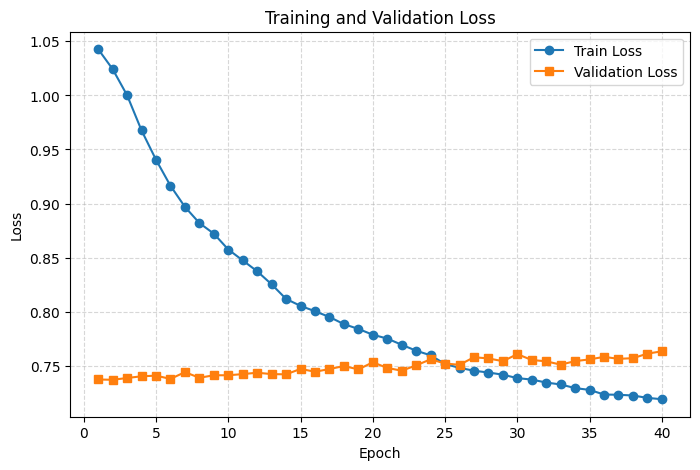

In [85]:
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [86]:
# # ---- Test MAE ----
# model.eval()
# test_sum = 0.0
# with torch.no_grad(), torch.cuda.amp.autocast(enabled=(device=='cuda')):
#     for xb, yb in test_loader:
#         pred = model(xb)
#         test_sum += crit(pred, yb).item() * xb.size(0)
# test_mae = test_sum / len(test_loader.dataset)
# print('✅ Test MAE:', test_mae)

# # ---- Loss curves ----
# import matplotlib.pyplot as plt
# plt.plot(train_losses, label='Train')
# plt.plot(val_losses, label='Val')
# plt.title('Loss'); plt.xlabel('Epoch'); plt.ylabel('SmoothL1')
# plt.legend(); plt.grid(True); plt.show()

# # ---- ตัวอย่าง Predict vs Actual (ก้อนสุดท้ายของ test set) ----
# with torch.no_grad():
#     xb, yb = next(iter(test_loader))
#     pred = model(xb).cpu().numpy()[0]
#     true = yb.cpu().numpy()[0]

# plt.plot(true, label='True')
# plt.plot(pred, label='Pred')
# plt.title('7-day log-return forecast'); plt.legend(); plt.grid(True); plt.show()

# Inference

In [87]:
X_test_dict

{'AAPL': (array([[[-0.43916417, -0.44499025, -1.00690287, ...,  6.48873166,
           -0.69869861,  1.41393339],
          [ 0.15294734, -0.45705955, -0.0848411 , ...,  6.60978581,
            0.81819193,  0.92632786],
          [-0.27538332, -0.57461108, -0.60220609, ...,  6.64564001,
            1.19283295, -0.16931184],
          ...,
          [ 0.18567901,  0.22145236, -0.14142454, ...,  0.11640998,
            1.19283295, -0.16931184],
          [-0.42955954, -0.5250236 ,  0.17457329, ..., -0.15872133,
            0.14311213, -1.04794666],
          [-0.39337056,  2.91532075,  1.52192484, ...,  0.06839698,
           -1.54050935, -1.04794666]],
  
         [[ 0.15294734, -0.45705955, -0.0848411 , ...,  6.60978581,
            0.81819193,  0.92632786],
          [-0.27538332, -0.57461108, -0.60220609, ...,  6.64564001,
            1.19283295, -0.16931184],
          [ 0.20927375, -0.64343594,  0.26132269, ...,  6.65925147,
            0.14311213, -1.04794666],
          ...,
    

In [88]:
test_datasets = {}
for ticker, (X, y) in X_test_dict.items():
    test_datasets[ticker] = TimeSeriesDataset(X, y)

In [90]:
test_datasets['AAPL'][0]

(tensor([[-0.4392, -0.4450, -1.0069,  ...,  6.4887, -0.6987,  1.4139],
         [ 0.1529, -0.4571, -0.0848,  ...,  6.6098,  0.8182,  0.9263],
         [-0.2754, -0.5746, -0.6022,  ...,  6.6456,  1.1928, -0.1693],
         ...,
         [ 0.1857,  0.2215, -0.1414,  ...,  0.1164,  1.1928, -0.1693],
         [-0.4296, -0.5250,  0.1746,  ..., -0.1587,  0.1431, -1.0479],
         [-0.3934,  2.9153,  1.5219,  ...,  0.0684, -1.5405, -1.0479]]),
 tensor([-1.8116,  1.0135, -0.1225,  0.1148, -1.2908]))

In [91]:
for ticker, dataset in test_datasets.items():
    loader = DataLoader(dataset, batch_size=64, shuffle=False)
    print(f"{ticker}: {len(dataset)} samples")


AAPL: 185 samples
MSFT: 185 samples
NVDA: 185 samples
TSLA: 185 samples
GOOGL: 185 samples
AMZN: 185 samples
META: 185 samples
NFLX: 185 samples
AMD: 185 samples
INTC: 185 samples
JPM: 185 samples
V: 185 samples
MA: 185 samples
ORCL: 185 samples
XOM: 185 samples
COST: 185 samples
WMT: 185 samples
PG: 185 samples
JNJ: 185 samples
ADBE: 185 samples
BAC: 185 samples
KO: 185 samples
PEP: 185 samples
CSCO: 185 samples
CRM: 185 samples
T: 185 samples
MCD: 185 samples
HON: 185 samples
IBM: 185 samples
QCOM: 185 samples
UPS: 185 samples
PM: 185 samples
CVX: 185 samples
BA: 185 samples
SBUX: 185 samples
GS: 185 samples
CAT: 185 samples
AXP: 185 samples
MDT: 185 samples
AMGN: 185 samples
BLK: 185 samples
SPGI: 185 samples
TXN: 185 samples
NEE: 185 samples
MMM: 185 samples
UNH: 185 samples
LIN: 185 samples
RTX: 185 samples
LOW: 185 samples
BKNG: 185 samples


In [92]:
scaler_dict = {
    t: scaler[i] for i, t in enumerate(tickers)
}

In [112]:
dfs_n = {}
for t in tickers:
    df_t = data[t][['Open','High','Low','Close','Volume']].dropna().copy()
    df_t['Ticker'] = t
    dfs_n[t] = df_t

In [111]:
base_close_dict = {
    ticker: dfs_n[ticker]['Close'].iloc[-len(test_datasets[ticker].y) - 1]
    for ticker in test_datasets.keys()
}

In [94]:
def reconstruct_close(base_close, logret_seq):
    close = [base_close]
    for lr in logret_seq:
        close.append(close[-1] * np.exp(lr))
    return np.array(close[1:])

In [110]:
model.eval()
model.to(device)

criterion = nn.MSELoss()
results = {}
total_loss = 0
total_count = 0

past_step = X_train.shape[1]  # input sequence length

with torch.no_grad():
    for ticker, dataset in test_datasets.items():
        X, y = dataset.X.to(device), dataset.y.to(device)
        logret_scaler = scaler_dict[ticker]['log_ret']

        # Predict log-returns
        preds = model(X)

        # Move to CPU & numpy
        preds_np = preds.cpu().numpy()
        y_np = y.cpu().numpy()

        # Inverse scale
        preds_inv = logret_scaler.inverse_transform(preds_np)
        y_inv = logret_scaler.inverse_transform(y_np)

        # Reconstruct close prices per sample using last price of input window
        pred_close_all, true_close_all = [], []
        for i in range(preds_inv.shape[0]):
            # Get last known close from input window
            base_close = dfs_n[ticker]['Close'].iloc[i + past_step - 1]

            pred_close = reconstruct_close(base_close, preds_inv[i])
            true_close = reconstruct_close(base_close, y_inv[i])

            pred_close_all.append(pred_close)
            true_close_all.append(true_close)

        pred_close_all = np.array(pred_close_all)
        true_close_all = np.array(true_close_all)

        # Compute MSE per ticker
        mse = ((pred_close_all - true_close_all) ** 2).mean()
        results[ticker] = mse

        # Accumulate for overall
        total_loss += mse * X.shape[0]
        total_count += X.shape[0]

overall_mse = total_loss / total_count

print("📊 Test MSE Results on reconstructed close prices")
for t, l in results.items():
    print(f"  {t:>6}: {l:.6f}")
print(f"  {'Overall':>6}: {overall_mse:.6f}")


📊 Test MSE Results on reconstructed close prices
    AAPL: 4.017868
    MSFT: 8.746626
    NVDA: 0.153990
    TSLA: 3.419828
   GOOGL: 5.902643
    AMZN: 13.066534
    META: 84.257021
    NFLX: 249.355801
     AMD: 2.612636
    INTC: 10.806839
     JPM: 16.432056
       V: 16.894770
      MA: 39.381599
    ORCL: 9.641742
     XOM: 5.554065
    COST: 39.172188
     WMT: 0.835780
      PG: 2.264746
     JNJ: 5.445686
    ADBE: 83.195549
     BAC: 1.219136
      KO: 0.639655
     PEP: 5.352700
    CSCO: 0.964700
     CRM: 29.904153
       T: 0.166425
     MCD: 8.491360
     HON: 11.937839
     IBM: 17.001400
    QCOM: 5.556419
     UPS: 9.293499
      PM: 3.930250
     CVX: 10.115575
      BA: 223.495780
    SBUX: 5.048241
      GS: 92.577654
     CAT: 26.357942
     AXP: 18.593374
     MDT: 3.448071
    AMGN: 25.684117
     BLK: 214.044672
    SPGI: 39.928077
     TXN: 22.212376
     NEE: 1.441701
     MMM: 26.913675
     UNH: 252.632675
     LIN: 13.467394
     RTX: 7.215777
     LOW: 6

In [97]:
results

{'AAPL': np.float64(96.27110947416315),
 'MSFT': np.float64(147.03295557934405),
 'NVDA': np.float64(74.32946984825463),
 'TSLA': np.float64(963.6262517725115),
 'GOOGL': np.float64(62.288548002844585),
 'AMZN': np.float64(85.92305560842455),
 'META': np.float64(1365.3404230896476),
 'NFLX': np.float64(2084.7667112464983),
 'AMD': np.float64(70.78943533358324),
 'INTC': np.float64(2.1302913333881204),
 'JPM': np.float64(146.5737488541561),
 'V': np.float64(114.64120080614354),
 'MA': np.float64(320.5296895337541),
 'ORCL': np.float64(156.88399591252875),
 'XOM': np.float64(18.19003966922971),
 'COST': np.float64(1110.8888409150834),
 'WMT': np.float64(11.521754338524955),
 'PG': np.float64(13.119077010053962),
 'JNJ': np.float64(10.614273662049692),
 'ADBE': np.float64(253.4440070570279),
 'BAC': np.float64(4.2854654814341755),
 'KO': np.float64(1.9126753752428138),
 'PEP': np.float64(13.322307235841635),
 'CSCO': np.float64(2.7582821322305446),
 'CRM': np.float64(159.58402389608895),


In [98]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [113]:
def merge_overlapping_closes(pred_close_matrix):
    """
    pred_close_matrix: shape (n_samples, horizon)
    Merge overlapping reconstructed close sequences by averaging each overlapping timestep.
    """
    n_samples, horizon = pred_close_matrix.shape
    merged = np.zeros(n_samples + horizon - 1)
    counts = np.zeros_like(merged)

    for i in range(n_samples):
        merged[i:i+horizon] += pred_close_matrix[i]
        counts[i:i+horizon] += 1

    return merged / counts


def plot_stock_predictions_reconstructed(preds_dict, y_test_dict, dfs_n, scaler_dict, past_step=90):
    """
    preds_dict: predicted log-return arrays per ticker (n_samples, horizon)
    y_test_dict: true log-return arrays per ticker (n_samples, horizon)
    dfs_n: dictionary of original dataframes with Close prices
    """
    for ticker in preds_dict.keys():
        pred_logret = preds_dict[ticker]
        true_logret = y_test_dict[ticker]
        logret_scaler = scaler_dict[ticker]['log_ret']

        # Inverse scale
        pred_inv = logret_scaler.inverse_transform(pred_logret)
        true_inv = logret_scaler.inverse_transform(true_logret)

        # Reconstruct close per sample
        pred_close_matrix = []
        true_close_matrix = []

        for i in range(pred_inv.shape[0]):
            base_close = dfs_n[ticker]['Close'].iloc[i + past_step - 1]  # last input price
            pred_close_matrix.append(reconstruct_close(base_close, pred_inv[i]))
            true_close_matrix.append(reconstruct_close(base_close, true_inv[i]))

        pred_close_matrix = np.array(pred_close_matrix)
        true_close_matrix = np.array(true_close_matrix)

        # Merge overlapping reconstructed closes
        pred_close = merge_overlapping_closes(pred_close_matrix)
        true_close = merge_overlapping_closes(true_close_matrix)

        # Align lengths
        min_len = min(len(pred_close), len(true_close))
        pred_close = pred_close[:min_len]
        true_close = true_close[:min_len]

        # Compute MSE
        mse = mean_squared_error(true_close, pred_close)
        print(f"{ticker} - MSE on reconstructed close prices: {mse:.6f}")

        # Plot
        plt.figure(figsize=(10, 5))
        plt.plot(true_close, label="True Close", color="black", linewidth=1.5)
        plt.plot(pred_close, label="Predicted Close", color="red", alpha=0.7)
        plt.title(f"{ticker} - Forecast vs Actual")
        plt.xlabel("Time Steps")
        plt.ylabel("Close Price")
        plt.legend()
        plt.grid(True, linestyle="--", alpha=0.4)
        plt.show()


AAPL - MSE on reconstructed close prices: 3.039063


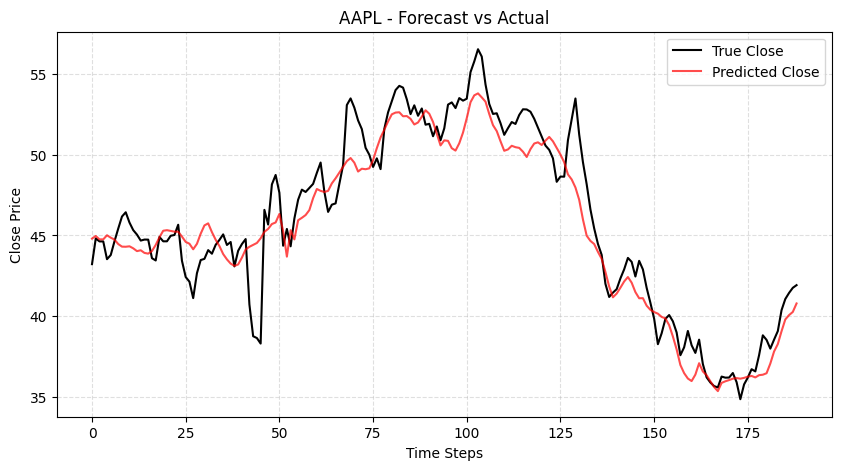

MSFT - MSE on reconstructed close prices: 6.594408


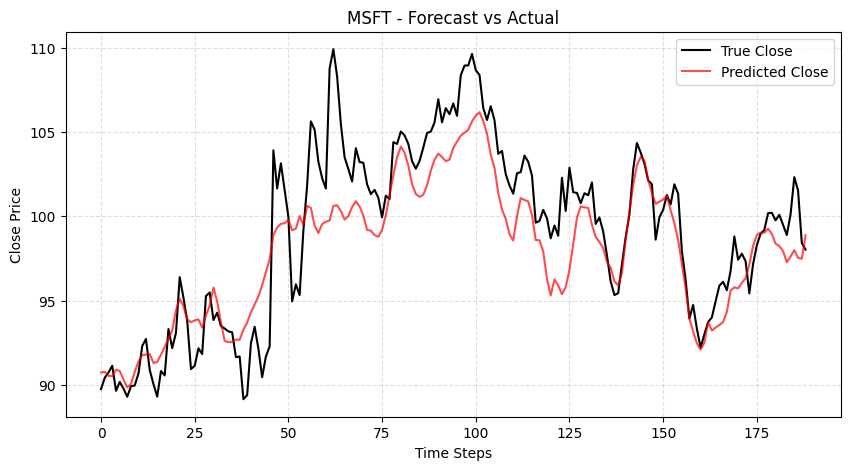

NVDA - MSE on reconstructed close prices: 0.123347


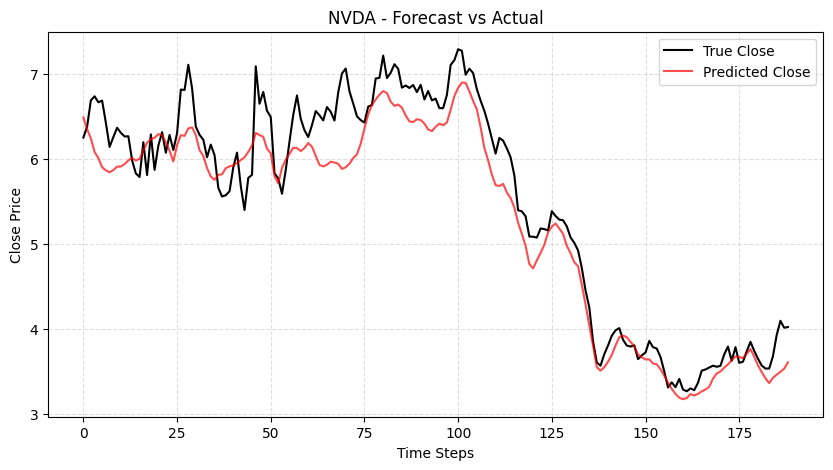

TSLA - MSE on reconstructed close prices: 2.583435


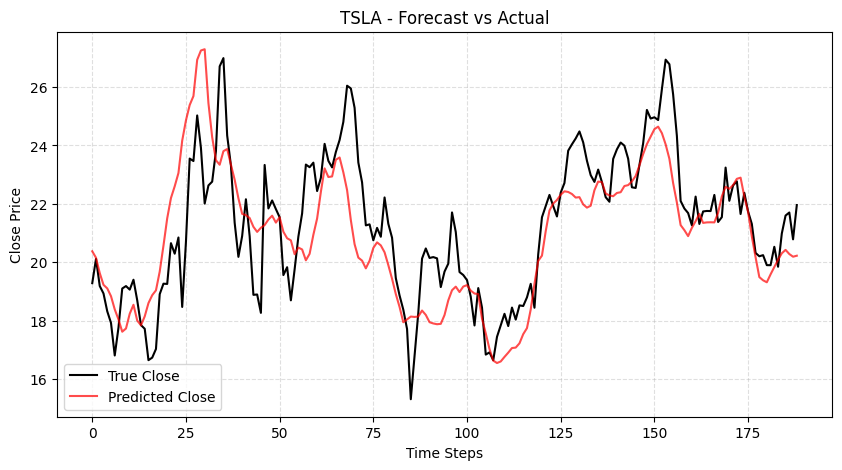

GOOGL - MSE on reconstructed close prices: 4.934452


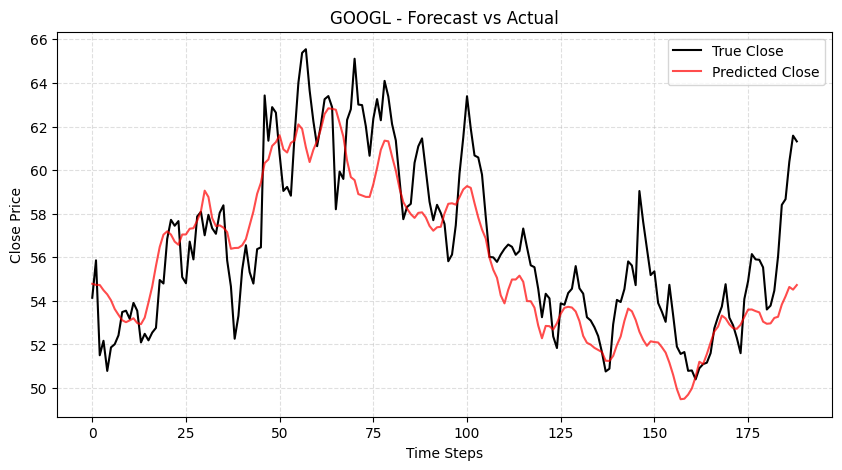

AMZN - MSE on reconstructed close prices: 9.980455


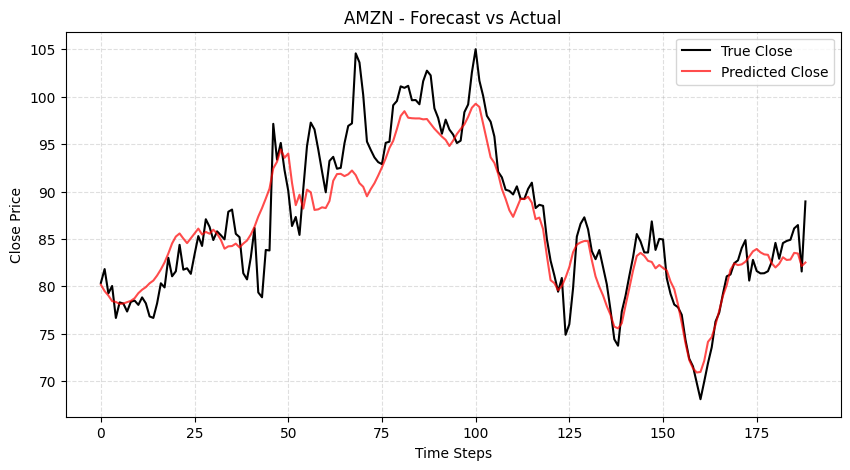

META - MSE on reconstructed close prices: 69.574249


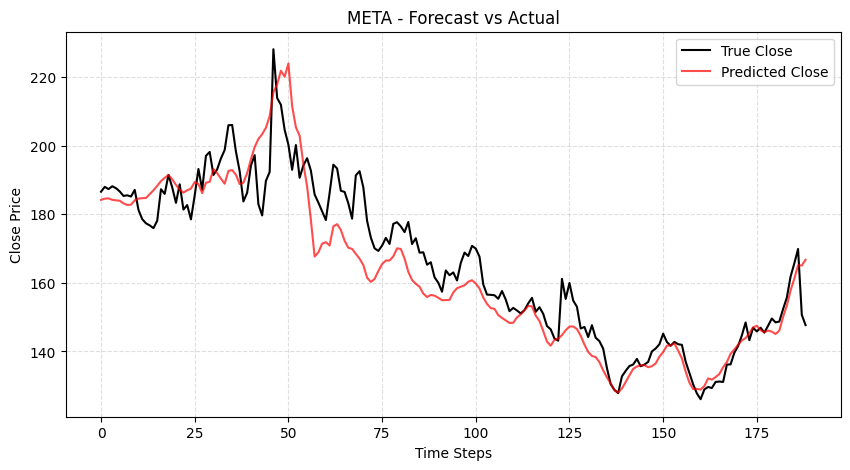

NFLX - MSE on reconstructed close prices: 190.022123


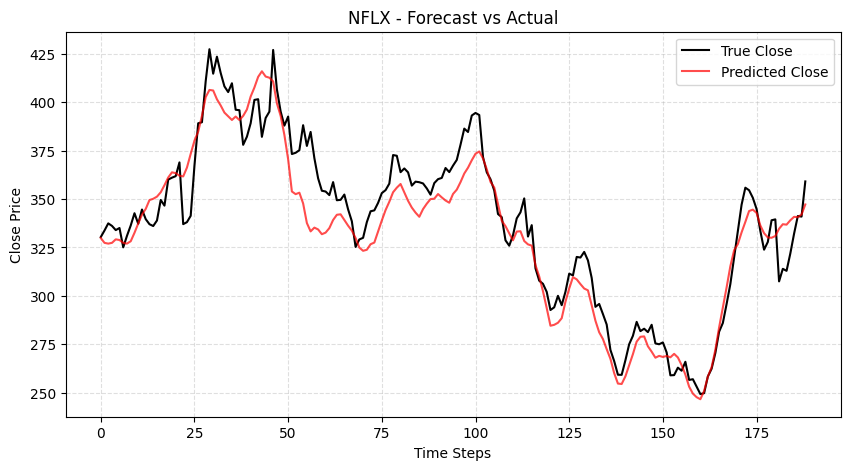

AMD - MSE on reconstructed close prices: 1.904970


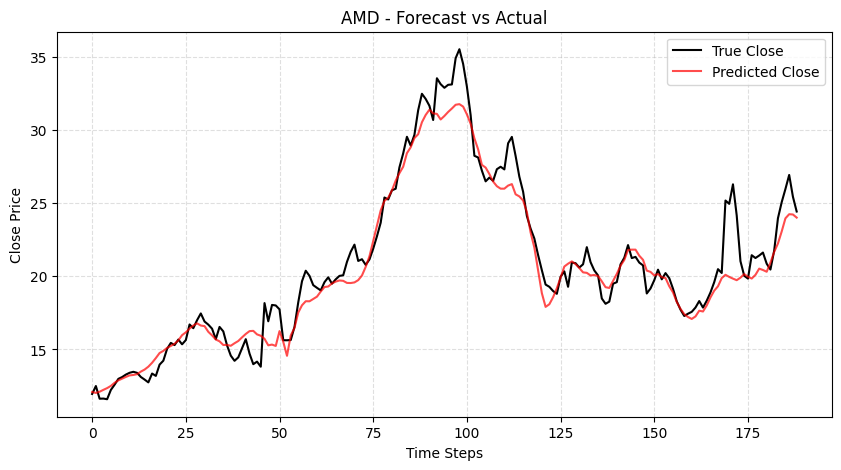

INTC - MSE on reconstructed close prices: 8.045202


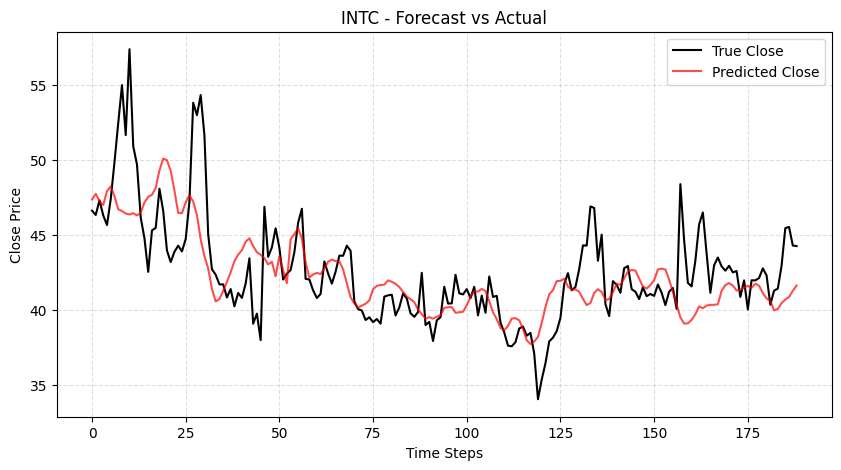

JPM - MSE on reconstructed close prices: 12.473644


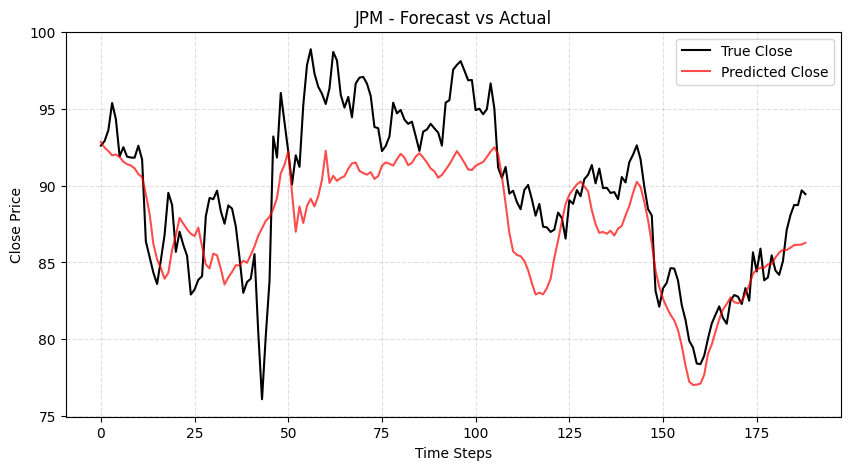

V - MSE on reconstructed close prices: 12.800225


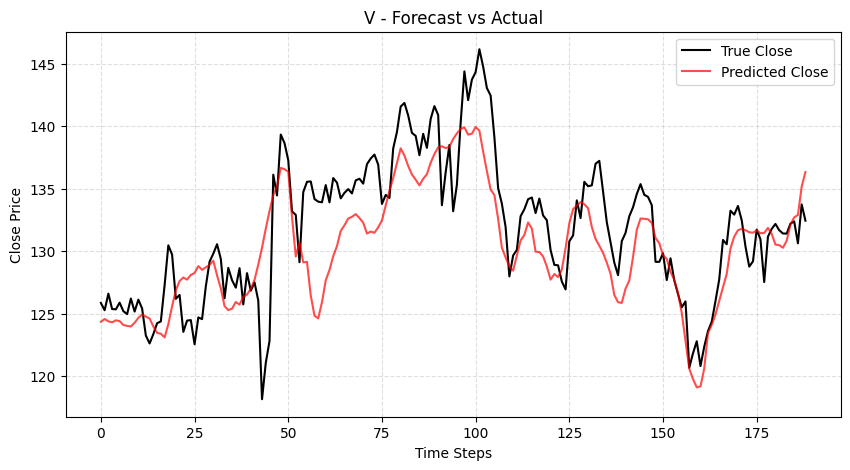

MA - MSE on reconstructed close prices: 29.699032


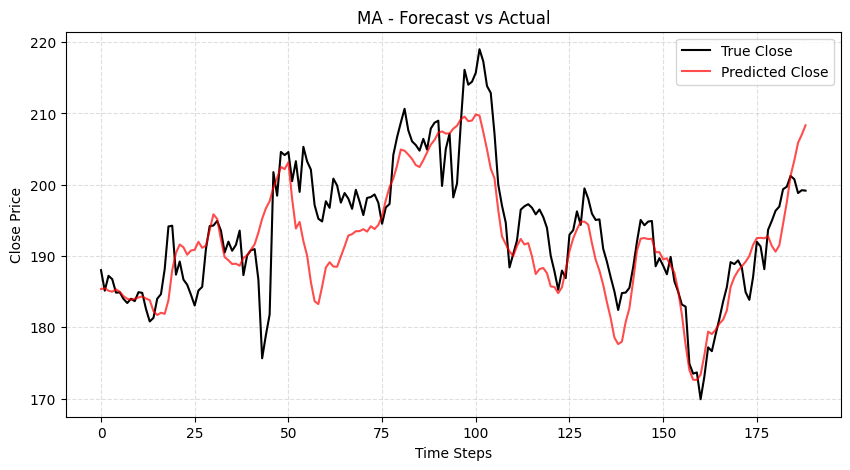

ORCL - MSE on reconstructed close prices: 7.261415


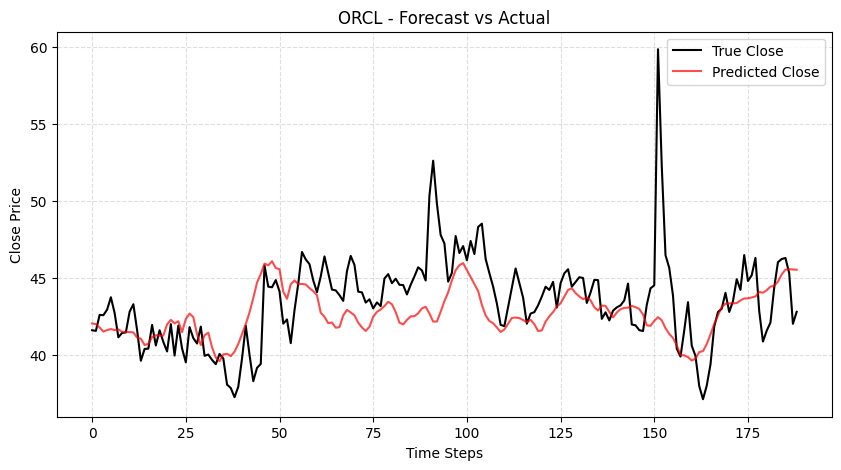

XOM - MSE on reconstructed close prices: 3.989973


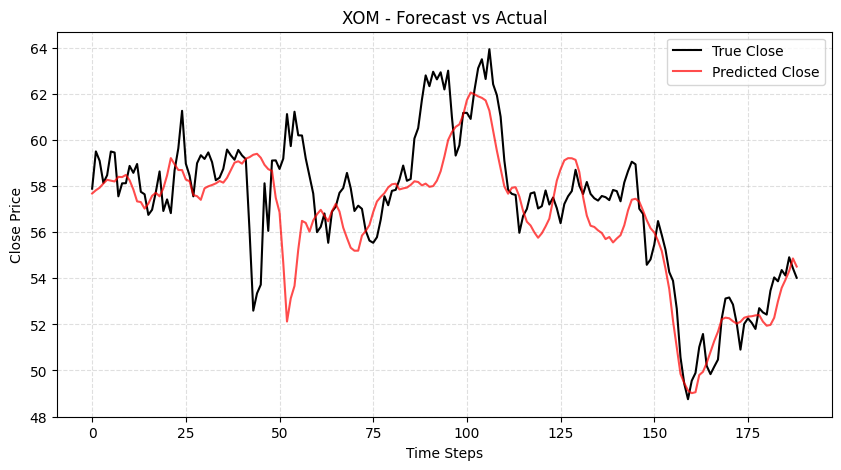

COST - MSE on reconstructed close prices: 30.485317


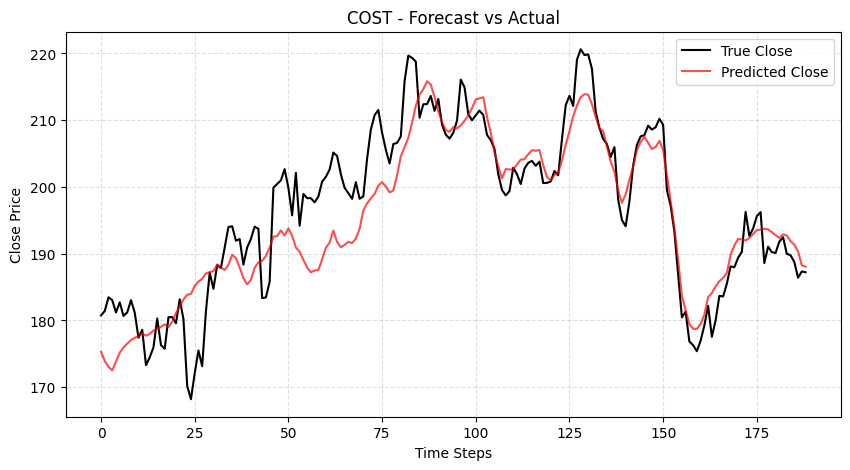

WMT - MSE on reconstructed close prices: 0.658777


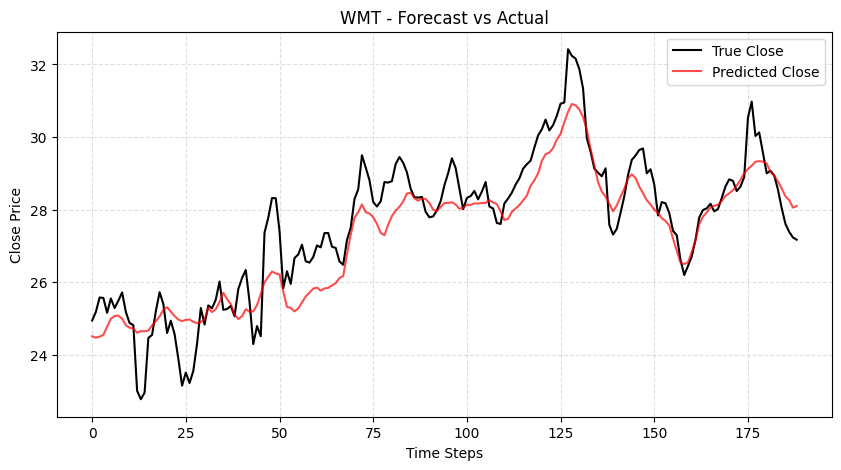

PG - MSE on reconstructed close prices: 1.708133


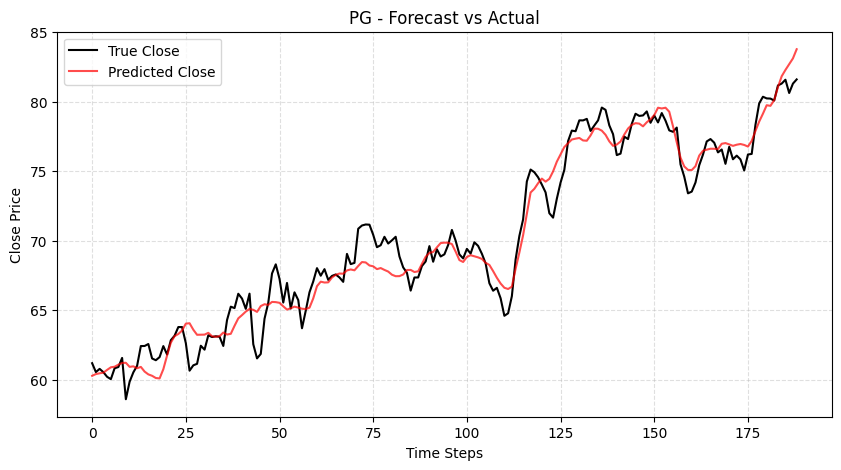

JNJ - MSE on reconstructed close prices: 3.993674


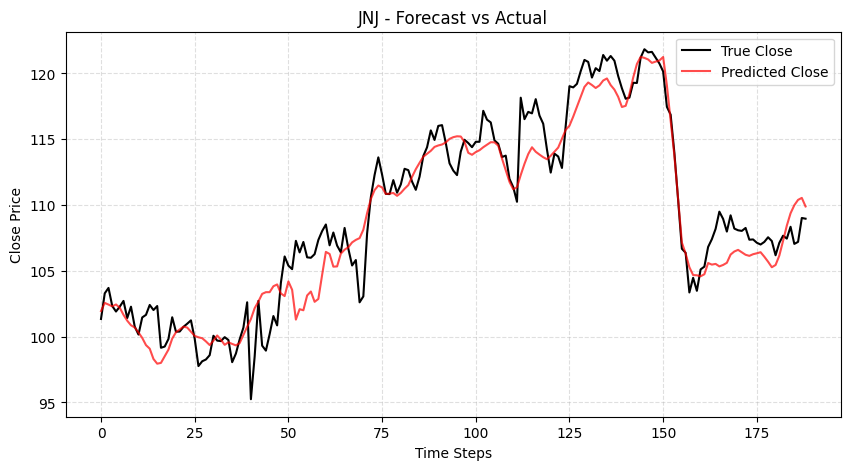

ADBE - MSE on reconstructed close prices: 59.865572


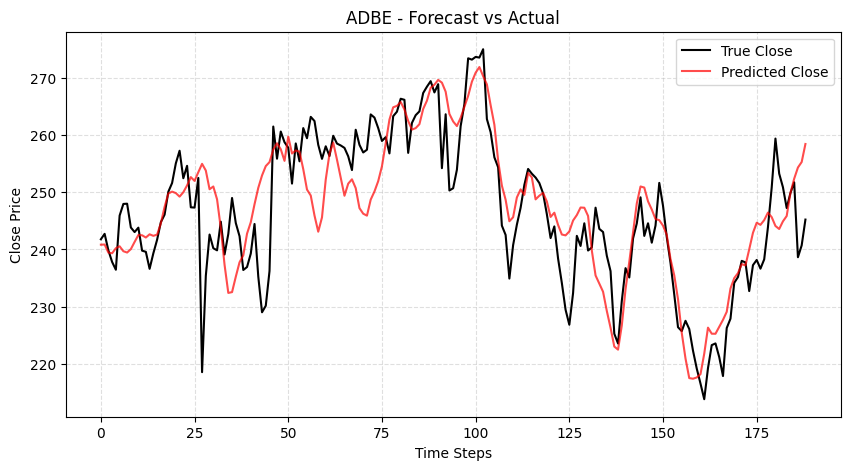

BAC - MSE on reconstructed close prices: 0.883828


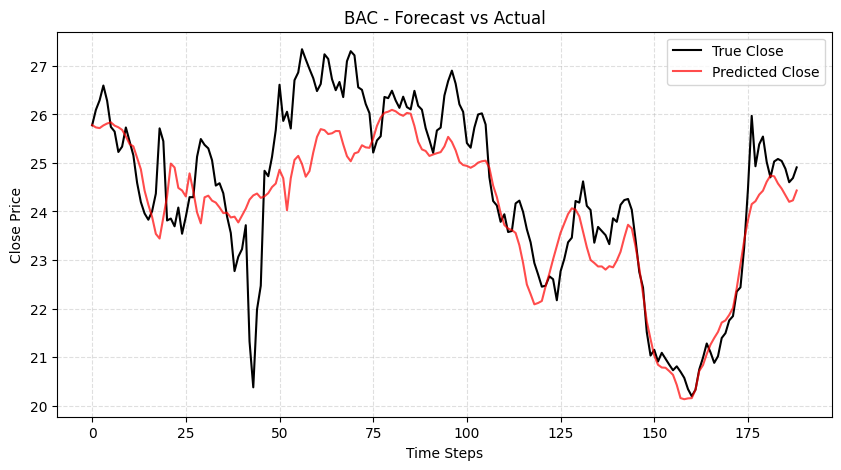

KO - MSE on reconstructed close prices: 0.474371


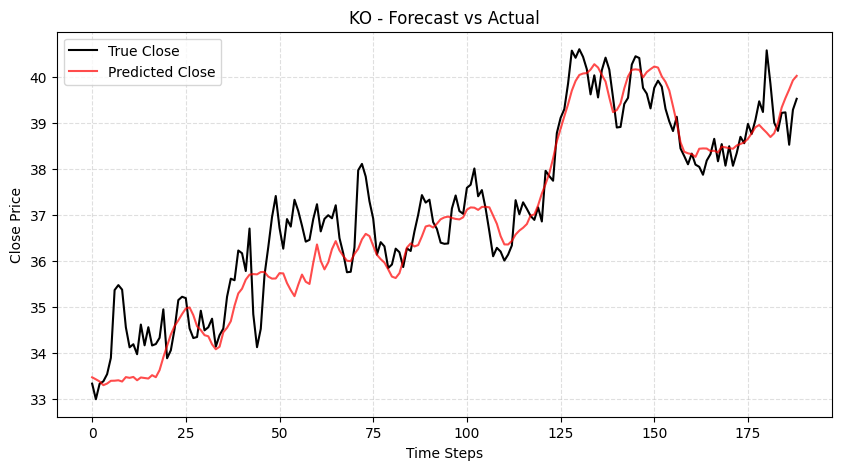

PEP - MSE on reconstructed close prices: 3.978642


CSCO - MSE on reconstructed close prices: 0.733060


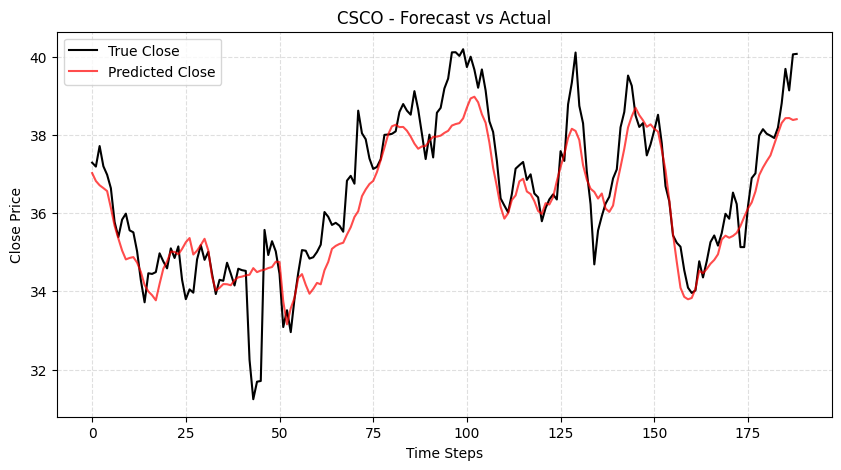

CRM - MSE on reconstructed close prices: 22.028890


T - MSE on reconstructed close prices: 0.126126


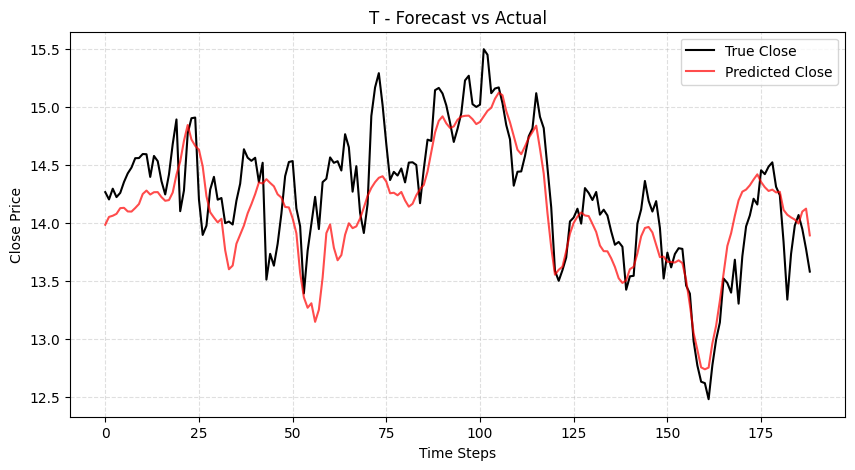

MCD - MSE on reconstructed close prices: 6.244245


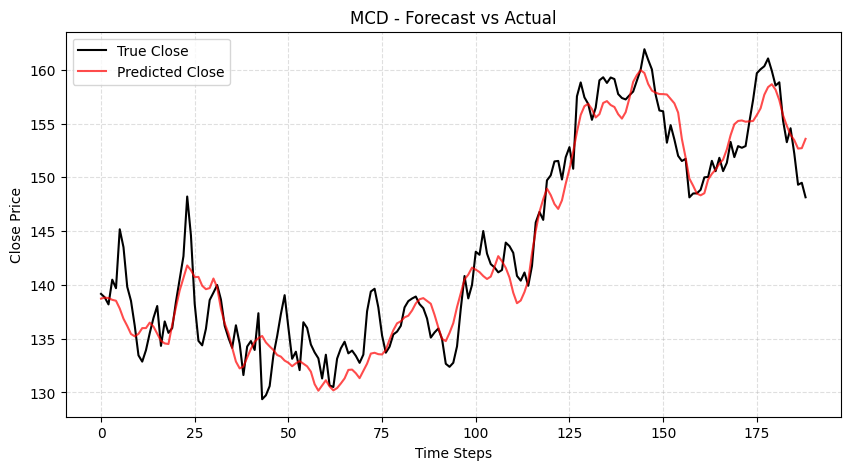

HON - MSE on reconstructed close prices: 8.554635


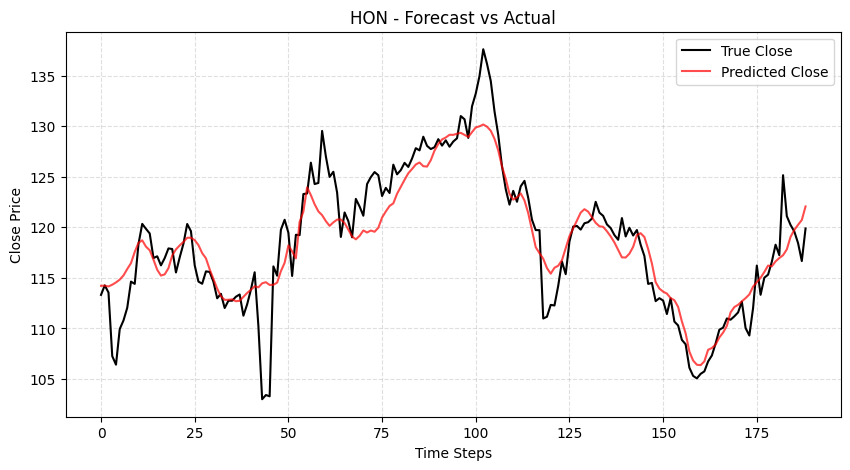

IBM - MSE on reconstructed close prices: 14.346457


QCOM - MSE on reconstructed close prices: 4.224072


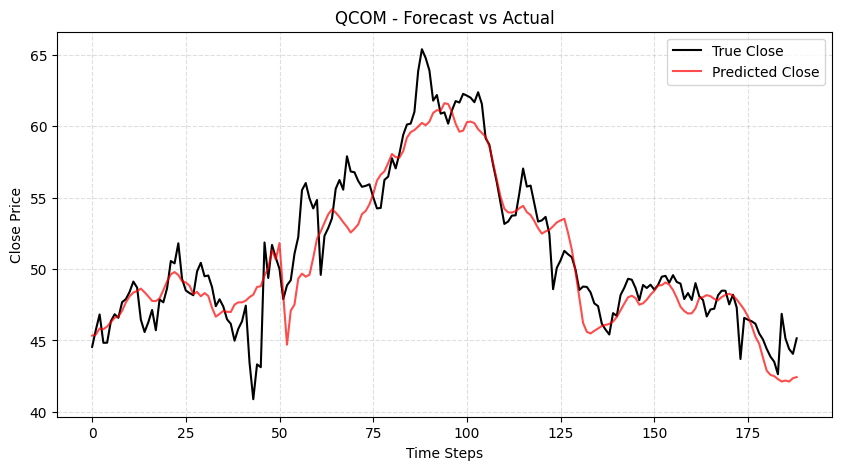

UPS - MSE on reconstructed close prices: 7.483860


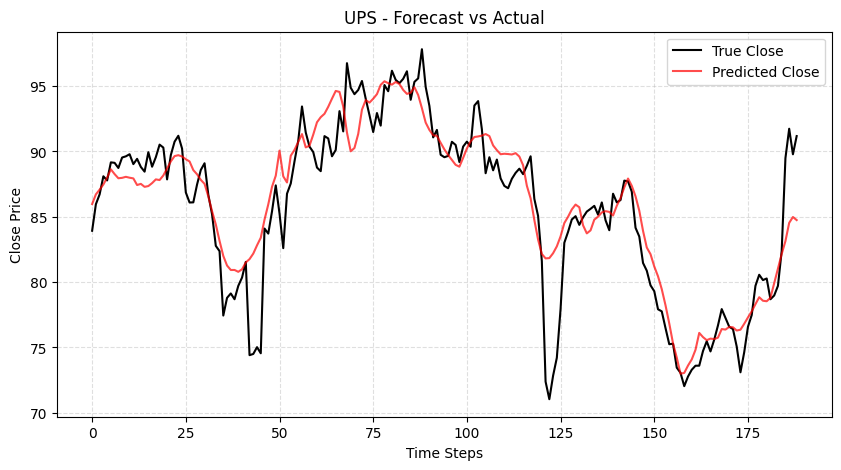

PM - MSE on reconstructed close prices: 3.105162


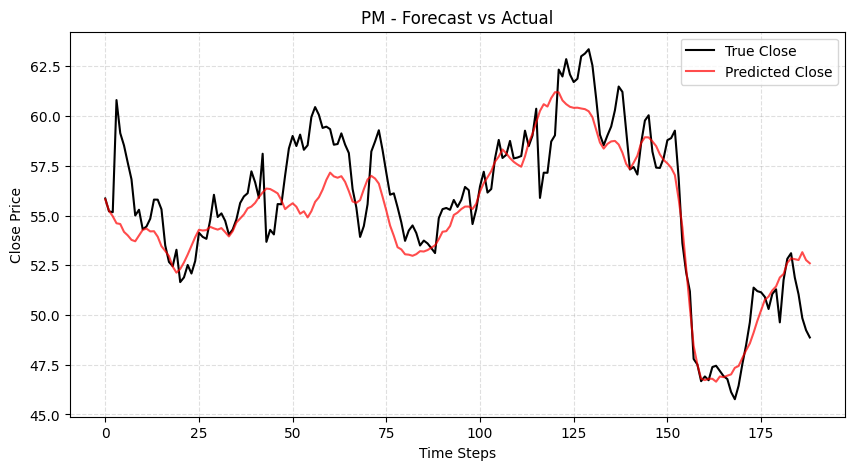

CVX - MSE on reconstructed close prices: 7.418864


BA - MSE on reconstructed close prices: 168.713275


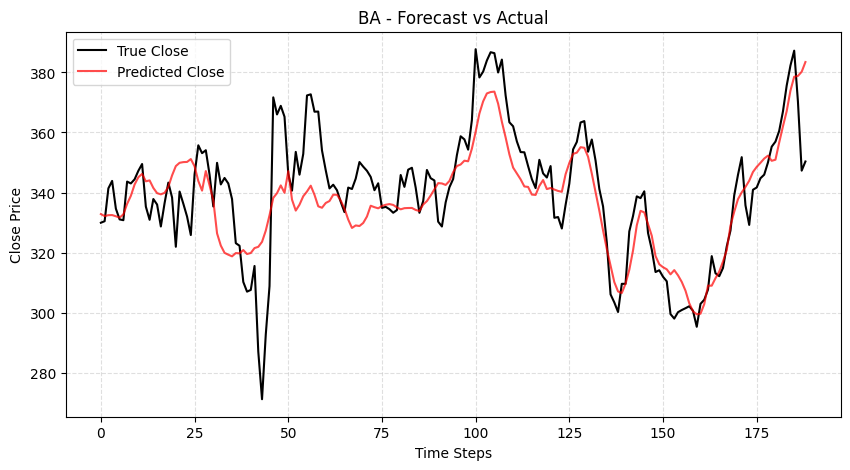

SBUX - MSE on reconstructed close prices: 3.882531


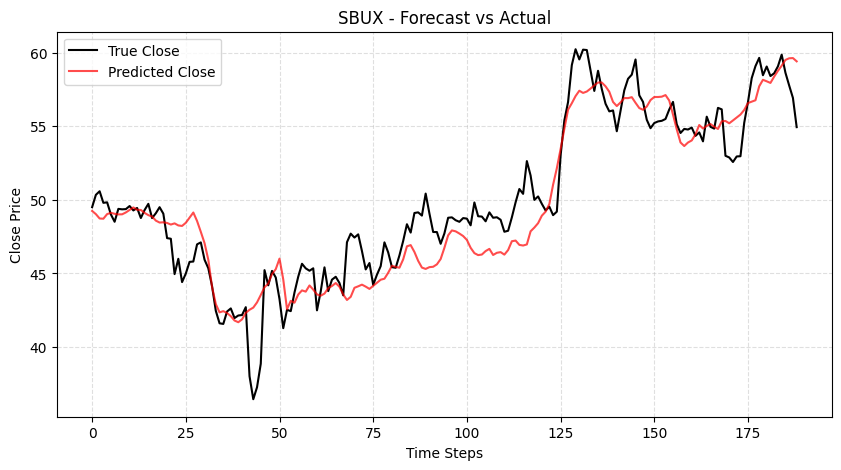

GS - MSE on reconstructed close prices: 73.436594


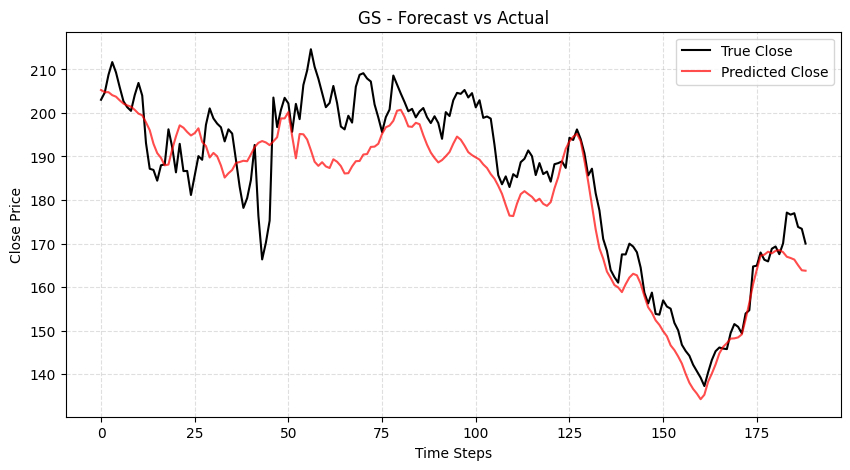

CAT - MSE on reconstructed close prices: 21.825185


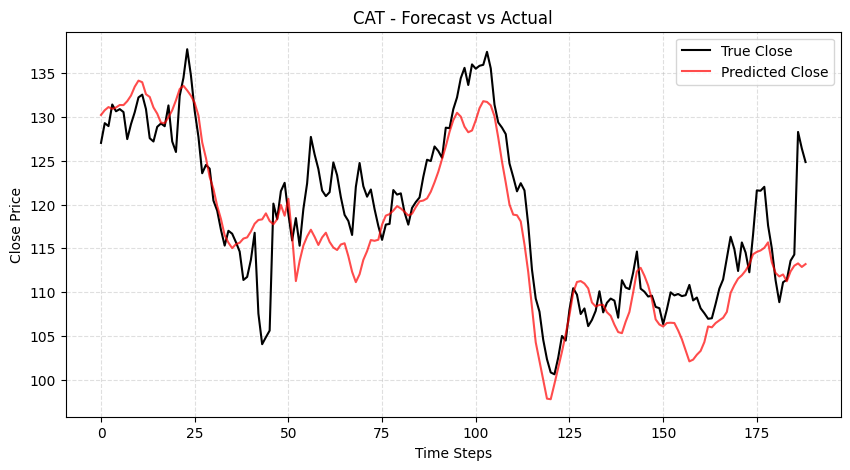

AXP - MSE on reconstructed close prices: 14.380117


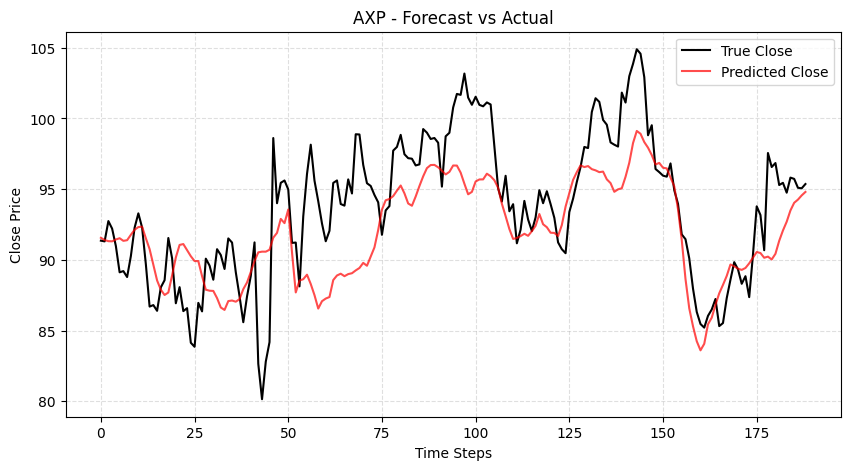

MDT - MSE on reconstructed close prices: 2.514992


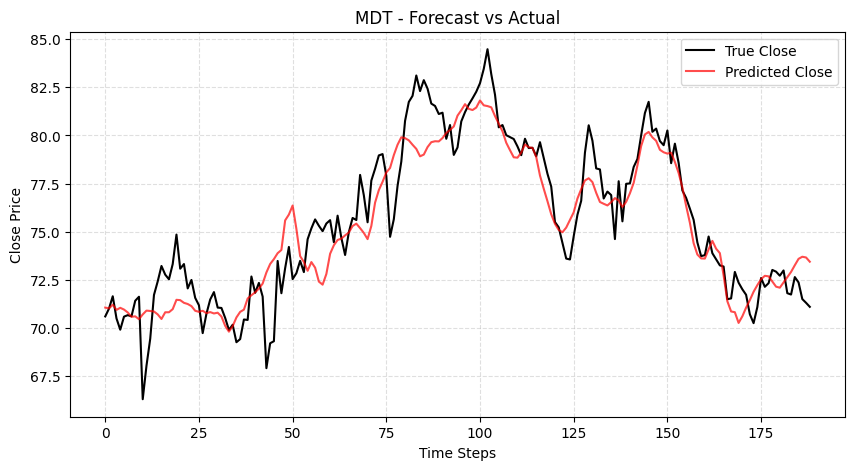

AMGN - MSE on reconstructed close prices: 19.140079


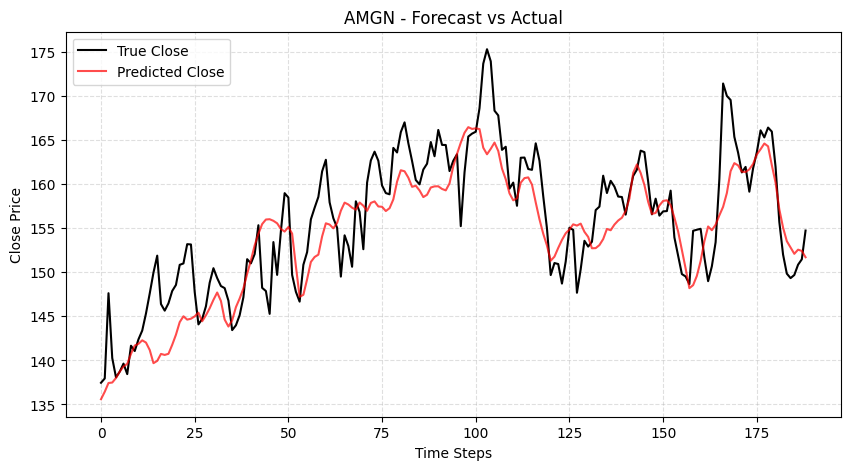

BLK - MSE on reconstructed close prices: 166.249722


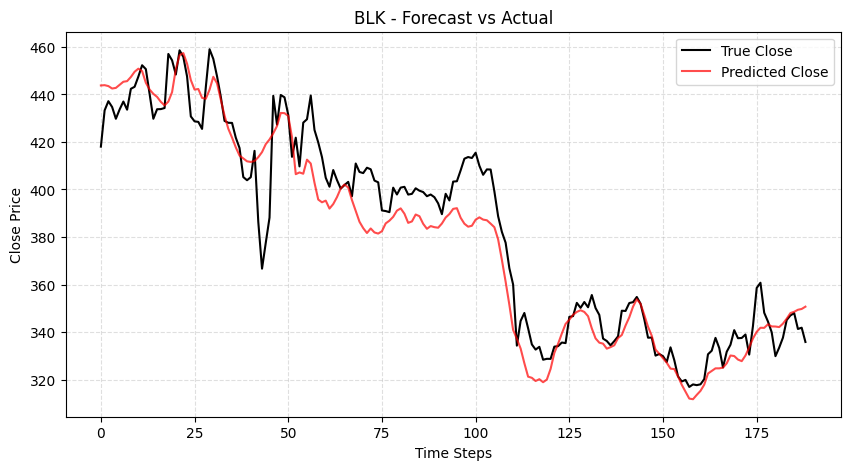

SPGI - MSE on reconstructed close prices: 28.811955


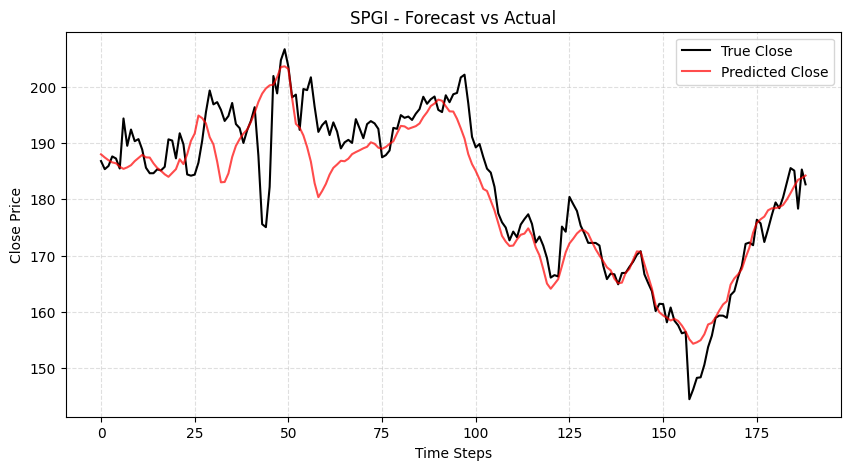

TXN - MSE on reconstructed close prices: 17.087539


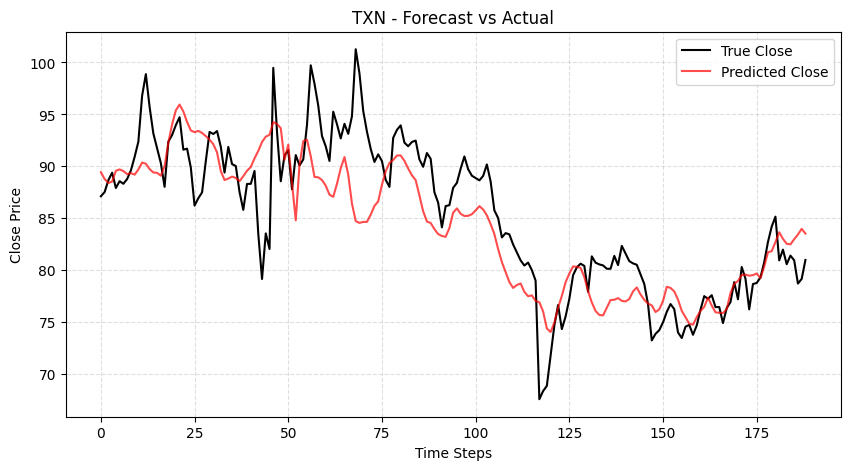

NEE - MSE on reconstructed close prices: 1.070343


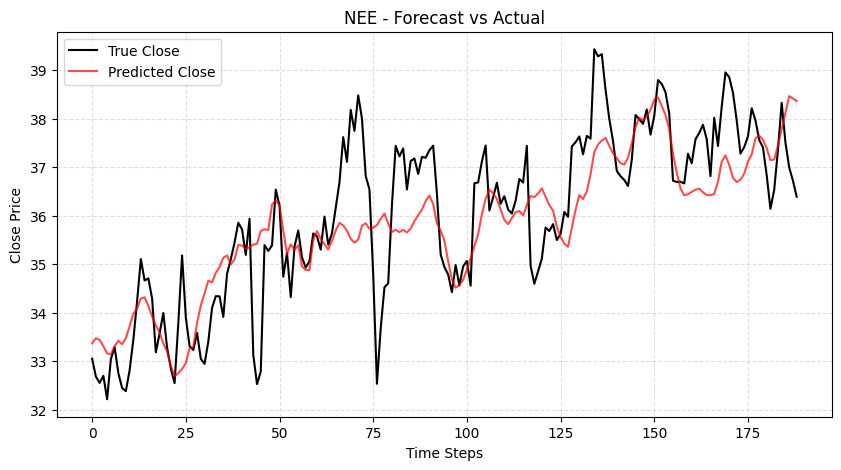

MMM - MSE on reconstructed close prices: 19.108447


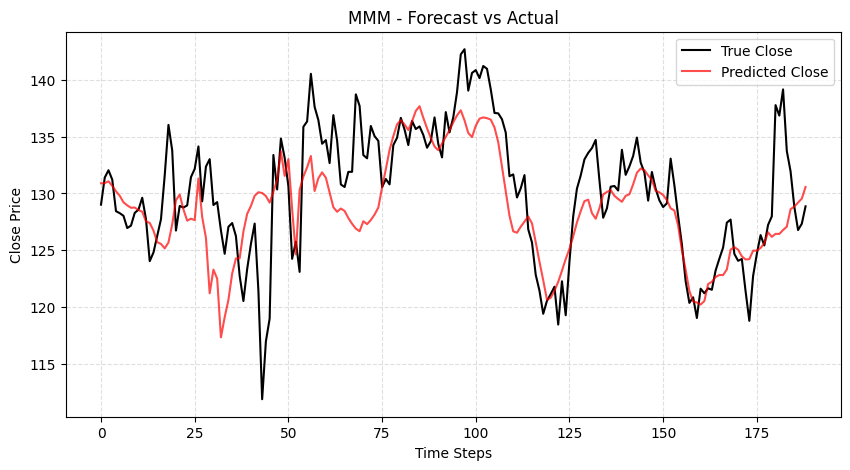

UNH - MSE on reconstructed close prices: 193.905500


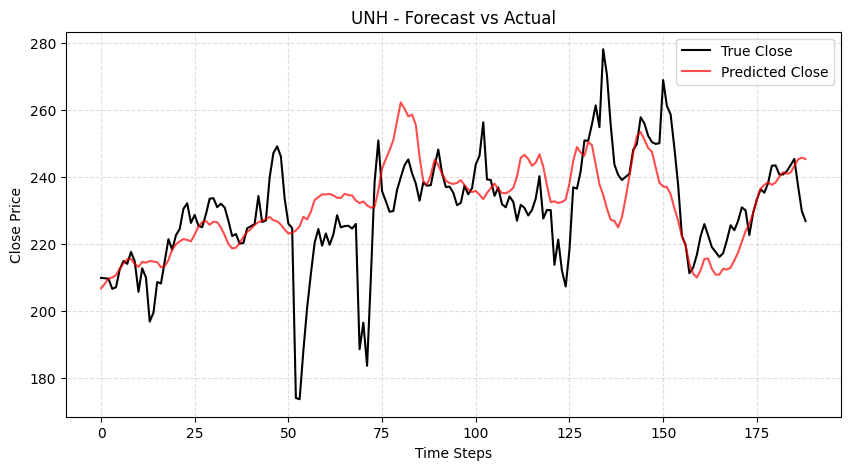

LIN - MSE on reconstructed close prices: 10.603909


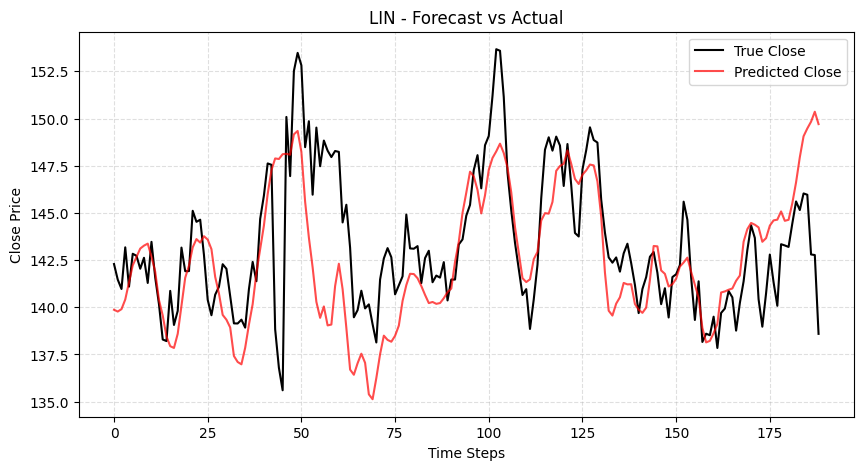

RTX - MSE on reconstructed close prices: 5.315345


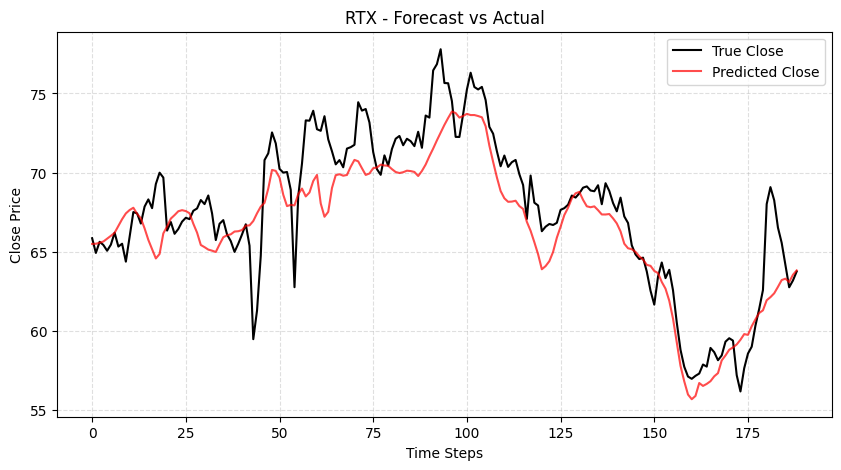

LOW - MSE on reconstructed close prices: 4.606256


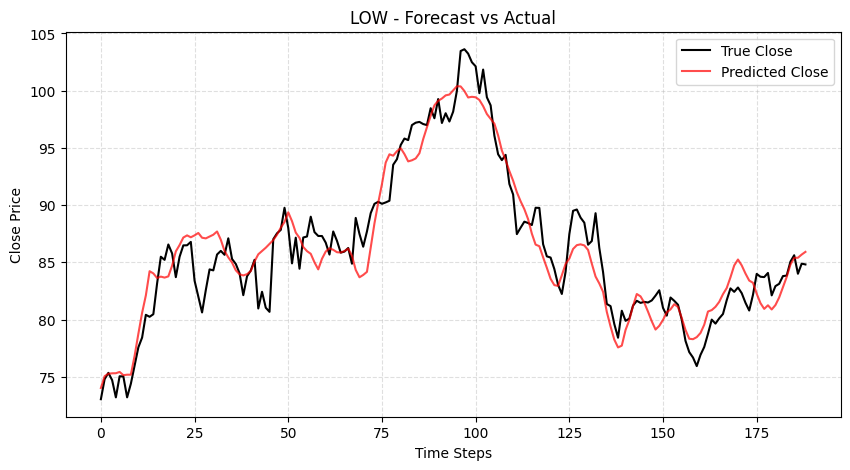

BKNG - MSE on reconstructed close prices: 4315.568618


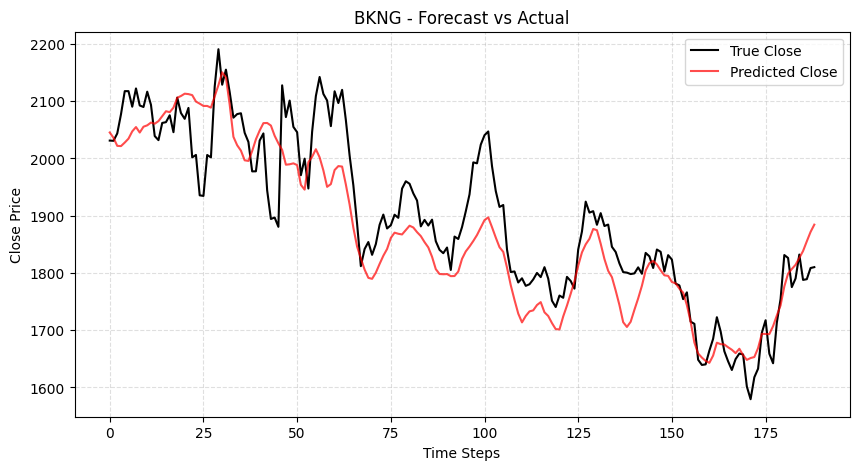

In [115]:
model.eval()
preds_dict = {}
y_test_dict = {}

with torch.no_grad():
    for ticker, dataset in test_datasets.items():
        X = dataset.X.to(device)
        y = dataset.y.to(device)

        preds = model(X)  # shape: [num_samples, horizon]

        preds_dict[ticker] = preds.cpu().numpy()
        y_test_dict[ticker] = y.cpu().numpy()

plot_stock_predictions_reconstructed(preds_dict, y_test_dict, dfs_n, scaler_dict)